## KGB Model LN Auto V2 - FICO 660 to 740

In [2]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [4]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Train_Funded_Data_250324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Test_Funded_Data_250324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Oot_Funded_Data_250324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_TTD_Data_250324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 347), (62938, 347), (37121, 345), (700580, 345))

In [5]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [6]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [7]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [8]:
Train.shape, Test.shape, Oot.shape

((146855, 347), (62938, 347), (37121, 345))

In [9]:
print(TTD.shape)
TTD= TTD[TTD['client']!= 'CPM'].reset_index(drop= True)
print(TTD.shape)
# TTD_Oot= TTD_Oot[TTD_Oot['client']!= 'CPM'].reset_index(drop= True)

(700580, 345)
(685215, 345)


In [11]:
Train= Train[all_cols + ['weight']]
Test= Test[all_cols + ['weight']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [12]:
Train.rename(columns= {'weight': 'wt2'}, inplace= True)
Test.rename(columns= {'weight': 'wt2'}, inplace= True)

In [13]:
Train= Train[(Train['fico_pb']>=660) & (Train['fico_pb']<= 740)].reset_index(drop= True)
print(Train.shape, Train['fico_pb'].agg(['min', 'max']))

Test= Test[(Test['fico_pb']>=660) & (Test['fico_pb']<= 740)].reset_index(drop= True)
print(Test.shape, Test['fico_pb'].agg(['min', 'max']))

Oot= Oot[(Oot['fico_pb']>=660) & (Oot['fico_pb']<= 740)].reset_index(drop= True)
print(Oot.shape, Oot['fico_pb'].agg(['min', 'max']))

TTD= TTD[(TTD['fico_pb']>=660) & (TTD['fico_pb']<= 740)].reset_index(drop= True)
print(TTD.shape, TTD['fico_pb'].agg(['min', 'max']))

(53556, 145) min    660.0
max    740.0
Name: fico_pb, dtype: float64
(22910, 145) min    660.0
max    740.0
Name: fico_pb, dtype: float64
(13665, 144) min    660.0
max    740.0
Name: fico_pb, dtype: float64
(228747, 144) min    660.0
max    740.0
Name: fico_pb, dtype: float64


In [14]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.013425199790873105, 0.014273243125272807, 0.013611416026344676)

In [15]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(72798.0, 53556, 22910)

In [16]:
TTD_lt_660= pd.concat([Train, Test]).reset_index(drop= True)
TTD_lt_660.shape

(76466, 145)

In [17]:
TTD_lt_660['client'].value_counts(dropna= False)

client
Arkansas    16147
Tower       13609
GESA        10647
Numerica    10074
Guardian     9113
SECU         7158
Bethpage     3842
CPM          3668
HFCU         1039
Hawaii        930
NCU           239
Name: count, dtype: int64

In [18]:
TTD_lt_660['bad_flag'].mean()

0.013679282295399263

In [19]:
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/Mono_Data
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/Data

In [20]:
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/'

In [21]:
del Train, Test

In [23]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
diff= 100
for i in np.random.randint(100, 10000, 50):
    Train, Test= train_test_split(TTD_lt_660, test_size= 0.3, random_state= i)
    if np.abs(Train['bad_flag'].mean() - Test['bad_flag'].mean())< diff:
        diff= np.abs(Train['bad_flag'].mean() - Test['bad_flag'].mean())
        print(i, Train.shape, Test.shape)
        print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
        print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())
    else:
        pass

7043 (53526, 145) (22940, 145)
0.013899787019392445 0.013164777680906714
0.016152315197805932 0.015826774034756064
3502 (53526, 145) (22940, 145)
0.013507454321264432 0.014080209241499565
0.015783018272840624 0.01668913066317888
9083 (53526, 145) (22940, 145)
0.013712961925045772 0.013600697471665214
0.016124255026615214 0.01589220243017067
8000 (53526, 145) (22940, 145)
0.013694279415611105 0.013644289450741063
0.016094576830173114 0.01596120774855935
6116 (53526, 145) (22940, 145)
0.013675596906176438 0.013687881429816914
0.01601998215068817 0.01613501086923166


In [24]:
Train, Test= train_test_split(TTD_lt_660, test_size= 0.3, random_state= 6116)
print(i, Train.shape, Test.shape)
print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())

1700 (53526, 145) (22940, 145)
0.013675596906176438 0.013687881429816914
0.01601998215068817 0.01613501086923166


In [25]:
pref= 'FICO_660_740'
Train.to_csv(f'{path_data}{pref}_Auto_train_raw_data_280324.csv', index= False)
Test.to_csv(f'{path_data}{pref}_Auto_test_raw_data_280324.csv', index= False)
Oot.to_csv(f'{path_data}{pref}_Auto_oot_raw_data_280324.csv', index= False)
TTD.to_csv(f'{path_data}{pref}_Auto_ttd_raw_data_280324.csv', index= False)

In [26]:
TTD_lt_660['fico_pb'].isnull().sum()

0

In [27]:
TTD_lt_660.groupby(['client']).agg(
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    bad_rate= ('bad_flag', 'mean')
)

,funded,bad,bad_rate
client,,,
Arkansas,16147.0,118.0,0.007308
Bethpage,3842.0,41.0,0.010672
CPM,3668.0,44.0,0.011996
GESA,10647.0,151.0,0.014182
Guardian,9113.0,56.0,0.006145
HFCU,1039.0,13.0,0.012512
Hawaii,930.0,0.0,0.000000
NCU,239.0,0.0,0.000000
Numerica,10074.0,147.0,0.014592


In [28]:
del TTD_lt_660

In [29]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.013675596906176438, 0.013687881429816914, 0.013611416026344676)

In [30]:
Train.shape, Train['funded_flag'].sum(), Test.shape, Test['funded_flag'].sum(), Oot.shape, Oot['funded_flag'].sum()

((53526, 145), 53526.0, (22940, 145), 22940.0, (13665, 144), 13665.0)

In [31]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [32]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [33]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     50879
[1]      2509
[2]       126
[-1]       12
Name: count, dtype: int64
bankruptcystatus
[0]     21777
[1]      1107
[2]        55
[-1]        1
Name: count, dtype: int64
bankruptcystatus
[0]    13010
[1]      616
[2]       39
Name: count, dtype: int64
bankruptcystatus
[0]     216331
[1]      11807
[2]        534
[-1]        75
Name: count, dtype: int64


#### Monotonic Binning

In [34]:
import pickle

configFile= Train[req_cols].dtypes.reset_index()
configFile.columns= ['Feature_Name', 'dtypes']
configFile['Special_values']= '[[-1]]'
# configFile['Monotonicity']= 'Y'
configFile['Monotonicity']= np.where(~configFile['Feature_Name'].isin(var_to_cat), 'Y', 'N')
del configFile['dtypes']
configFile.head()

,Feature_Name,Special_values,Monotonicity
0,assetpropevercount,[[-1]],Y
1,sourcenonderogcount06month,[[-1]],Y
2,addronfilecount,[[-1]],Y
3,addrinputcountyratio,[[-1]],Y
4,assetpropnewestsaleprice,[[-1]],Y


In [35]:
with open(f'{path_mono}configFile.pickle', 'wb') as f:
    pickle.dump(configFile, f)

In [36]:
dep_var = "bad_flag"
weight_column = 'wt2'
min_bin_size = 0.1
index_col=[]

In [37]:
# Get feature meta
# special_values = pd.read_csv(config_file)
import ast
special_values= configFile.copy()
# Converting the string entered in CSV to list of lists
special_values['Special_values'] = special_values['Special_values'].apply(lambda x: ast.literal_eval(str(x)))
# Generate feature meta
feature_meta = GenMeta(Train, index_col, sample_size=50000)
feature_meta = pd.merge(feature_meta, special_values, on="Feature_Name", how="left").replace(np.nan, '')
feature_meta.index = feature_meta['Feature_Name']
feature_meta.head()

,Feature_Name,Datatype,Special_values,Monotonicity
Feature_Name,,,,
unique_id,unique_id,string,,
client,client,string,,
app_date,app_date,string,,
approve_flag,approve_flag,float,,
funded_flag,funded_flag,float,,


In [38]:
with open(f'{path_mono}feature_meta.pickle', 'wb') as f:
    pickle.dump(feature_meta, f)

In [39]:
# Get numeric and embedding dataframe
embed_df, numeric_df = embedding_numeric_df(feature_meta, dep_var, index_col)

# Removing weight_column and columns that are not mentioned in the config file
embed_df.loc[np.invert(embed_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'
numeric_df.loc[
        np.invert(numeric_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'

if weight_column is not None:
    numeric_df.loc[numeric_df['Feature_Name'] == weight_column, 'Use_Feature'] = 'N'
    
display(numeric_df.head())
display(embed_df.head())

,Feature_Name,Use_Feature,Bucket_Size
Feature_Name,,,
approve_flag,approve_flag,N,10
funded_flag,funded_flag,N,10
fico_pb,fico_pb,N,10
fico_cb,fico_cb,N,10
bad_flag,bad_flag,N,10


,Feature_Name,Use_Feature,Num_Hash_Buckets,Num_Embedding_Columns
Feature_Name,,,,
unique_id,unique_id,N,10,2
client,client,N,10,2
app_date,app_date,N,10,2
product,product,N,10,2
Race,Race,N,10,2


In [40]:
with open(f'{path_mono}embed_df.pickle', 'wb') as f:
    pickle.dump(embed_df, f)

with open(f'{path_mono}numeric_df.pickle', 'wb') as f:
    pickle.dump(numeric_df, f)

In [41]:
# Get feature boundaries
feature_boundaries, numeric_df = get_boundaries_cart(filename=Train, sample_size=5000, shuffle_ind=False,
                                                         batch_size=100000,
                                                         shuffle_size=50000, feature_meta=feature_meta,
                                                         numeric_df=numeric_df,
                                                         dep_var=dep_var,
                                                         weight_column=weight_column, min_bin_size=float(min_bin_size))

assetpropevercount
0.0
assetpropevercount : [-inf, 1.0, 2.0, 3.0, inf]
sourcenonderogcount06month
0.0
sourcenonderogcount06month : [-inf, 2.0, inf]
addronfilecount
0.0
addronfilecount : [-inf, 2.0, 3.0, inf]
addrinputcountyratio
0.0
addrinputcountyratio : [-inf, 0.519999981, 0.819999993, 1.04999995, 1.44000006, inf]
assetpropnewestsaleprice
1.0
assetpropnewestsaleprice : [-inf, 70000.0, 112500.0, 136900.0, 375000.0, inf]
addrcurrenttaxvalue
0.0
addrcurrenttaxvalue : [-inf, 940.0, inf]
addrinputavmvalue
2367.0
addrinputavmvalue : [-inf, 83606.0, 139412.0, 287704.0, 366145.0, inf]
addrinputavmvalue60month
4107.0
addrinputavmvalue60month : [-inf, 64894.0, 290000.0, inf]
addrinputlastsaleprice
1.0
addrinputlastsaleprice : [-inf, 81000.0, 349900.0, inf]
addrinputtaxmarketvalue
0.0
addrinputtaxmarketvalue : [-inf, 4500.0, 125100.0, inf]
sourcecredheadertimeoldest
1.0
sourcecredheadertimeoldest : [-inf, 72.0, 262.0, inf]
addrinputphonecount
0.0
addrinputphonecount : [-inf, 1.0, inf]
assetprop

In [42]:
with open(f'{path_mono}feature_boundaries.pickle', 'wb') as f:
    pickle.dump(feature_boundaries, f)

In [43]:
# Get train bivar tables + get binned train dataframe
bivar_tables, rep_values, binned_df = get_bivar_tables(filename=Train, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [44]:
# Get train bivar tables + get binned train dataframe
bivar_tables_holdout, rep_values_holdout, binned_df_holdout = get_bivar_tables(filename=Test, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [45]:
# Get train bivar tables + get binned train dataframe
binned_df_oot = get_bivar_tables_test(filename=Oot, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [46]:
# Get train bivar tables + get binned train dataframe
binned_df_ttd = get_bivar_tables_test(filename=TTD, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [47]:
print(binned_df.shape, Train.shape)
print(binned_df_holdout.shape, Test.shape)
print(binned_df_oot.shape, Oot.shape)
print(binned_df_ttd.shape, TTD.shape)

(53526, 145) (53526, 145)
(22940, 145) (22940, 145)
(13665, 144) (13665, 144)
(228747, 144) (228747, 144)


In [48]:
binned_df.to_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_280324.csv', index= False)
binned_df_holdout.to_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_280324.csv', index= False)
binned_df_oot.to_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_280324.csv', index= False)
binned_df_ttd.to_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_280324.csv', index= False)

In [49]:
del Train, Test, Oot, TTD, binned_df, binned_df_holdout, binned_df_oot, binned_df_ttd

#### Reading Data For Model Building

In [5]:
import gc
gc.collect()

0

In [6]:
pref= 'FICO_660_740'
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/'

In [7]:
Train = pd.read_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_280324.csv')
Test = pd.read_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_280324.csv')
Oot= pd.read_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_280324.csv')
TTD= pd.read_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_280324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((53526, 145), (22940, 145), (13665, 144), (228747, 144))

In [8]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [9]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [10]:
Train[all_cols].head(2)

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,187771,Arkansas,2021-07-24,1.0,1.0,724.0,655.0,0.0,Auto,720.0,816.0,white,F,Age below 62,"[-inf, 1.0)","[-inf, 2.0)","[3.0, inf)","[-inf, 0.52)",[-1],"[-inf, 940.0)",[-1],[-1],[-1],"[-inf, 4500.0)","[262.0, inf)","[-inf, 1.0)",[-1],[-1],[-1],"[123.0, inf)","[22.0, 39.0)","[-inf, 7538.0)","[41.0, 136.0)","[-inf, 0.11)","[-inf, 2.0)","[-inf, 1.0)","[2.0, inf)","[4.0, inf)","[-inf, 877.0)","[-inf, 1.0)",[-1],"[-inf, 0.1)",[-1],"[-inf, 1.0)",[-1],"[-inf, 0.0775)","[-inf, 0.23)",[-1],"[157.0, 225.0)",[-1],"[-inf, 0.11)","[-inf, 0.205)","[-inf, 0.04)",[-1],"[-inf, 0.52)",[-1],"[261.0, inf)","[-inf, 4.516)",[-1],[-1],"[-inf, 956.181)",[-1],"[-inf, 2.51)",[-1],"[-inf, 0.0516)",[-1],"[23.0, 40.0)",[-1],"[-inf, 0.0198)","[-inf, 2.0)","[-inf, 0.0456)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],"[0.0, inf)",[0],[0],[0],"[161.0, 226.0)",[-1],[-1],[-1],[0],[0],[-1],[1],

In [11]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum(), 'Bad_Rate': Train['bad_flag'].mean()*100})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum(), 'Bad_Rate': Test['bad_flag'].mean()*100})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum(), 'Bad_Rate': Oot['bad_flag'].mean()*100})

{'Length': 53526.0, 'Bads': 732.0, 'Bad_Rate': 1.3675596906176437}
{'Length': 22940.0, 'Bads': 314.0, 'Bad_Rate': 1.3687881429816913}
{'Length': 13665.0, 'Bads': 186.0, 'Bad_Rate': 1.3611416026344676}


In [12]:
print(Train['fico_pb'].agg(['min', 'max']), Train['fico_pb'].isnull().sum())
print(Test['fico_pb'].agg(['min', 'max']), Test['fico_pb'].isnull().sum())
print(Oot['fico_pb'].agg(['min', 'max']), Oot['fico_pb'].isnull().sum())
print(TTD['fico_pb'].agg(['min', 'max']), TTD['fico_pb'].isnull().sum())

min    660.0
max    740.0
Name: fico_pb, dtype: float64 0
min    660.0
max    740.0
Name: fico_pb, dtype: float64 0
min    660.0
max    740.0
Name: fico_pb, dtype: float64 0
min    660.0
max    740.0
Name: fico_pb, dtype: float64 0


In [13]:
Train.shape, Test.shape, Oot.shape

((53526, 145), (22940, 145), (13665, 144))

In [14]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    53526.000000
mean         1.711047
std          0.498976
min          1.077272
50%          1.578290
90%          2.313824
95%          2.626641
99%          3.463317
max          8.998745
Name: wt2, dtype: float64

In [15]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,11424,1.120322,1.655424,8.997074
Bethpage,2705,1.077272,1.578959,4.603491
CPM,2569,1.105308,1.607557,6.333111
GESA,7432,1.087837,1.858341,8.998745
Guardian,6374,1.113928,1.812403,8.863393
HFCU,709,1.112439,1.734022,5.676549
Hawaii,664,1.139856,1.859867,4.097788
NCU,157,1.195244,1.755209,4.653740
Numerica,6965,1.096292,1.815087,6.767871


In [16]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((53526, 145), (22940, 145), (13665, 144), (228747, 144))

In [17]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [18]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [19]:
# for var in var_to_cat:
#     Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
#     Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
#     Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
#     TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [20]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     50879
[1]      2509
[2]       126
[-1]       12
Name: count, dtype: int64
bankruptcystatus
[0]     21777
[1]      1107
[2]        55
[-1]        1
Name: count, dtype: int64
bankruptcystatus
[0]    13010
[1]      616
[2]       39
Name: count, dtype: int64
bankruptcystatus
[0]     216331
[1]      11807
[2]        534
[-1]        75
Name: count, dtype: int64


In [21]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [22]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/'

In [23]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(53526.0, (53526, 145), 732.0, 0.013675596906176438)

In [24]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(22940.0, (22940, 145), 314.0, 0.013687881429816914)

In [25]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [26]:
# df_bv= pd.DataFrame()

# for col in req_cols:
#     print(col)
#     ### Train
#     temp_tr= Train.groupby(col).agg(
#         bad_count_tr= ('bad_flag', 'sum'),
#         bad_rate_tr= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_tr= ('p1', 'mean'),
#                                    volume_tr= ('unique_id', 'count')).reset_index()
#     temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
#     temp_tr.insert(0, 'variable', col)
    
#     # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
#     # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
#     ### Test
#     temp_te= Test.groupby(col).agg(
#         bad_count_te= ('bad_flag', 'sum'),
#         bad_rate_te= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_te= ('p1', 'mean'),
#                                   volume_te= ('unique_id', 'count')).reset_index()
#     temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
#     #temp_te['variable']= col
    
#     # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
#     # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
#     # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
#     # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
#     ### Concatenating
#     temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
#     # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
#     temp= Bucket_Order(temp)
#     # display(temp)
    
#     df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
#     del temp, temp_tr, temp_te

In [27]:
pd.options.display.max_rows= 1000
# df_bv

In [28]:
# var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
# var_trend_break, len(var_trend_break)

In [29]:
var_trend_break= ['assetpropnewestsaleprice',
  'addrinputavmvalue',
  'addrinputlastsaleprice',
  'addrcurrentavmvalue',
  'assetproppurchasetimeoldest',
  'addrpreviouslengthofres',
  'addrinputlengthofres',
  'addrcurrenttractratio',
  'addrinputsubjectcount',
  'businessassociationtimeoldest',
  'addrinputtractratio',
  'derogtimenewest',
  'addrinputtimelastsale',
  'educationinstitutionprivate',
  'addrinputblockratio',
  'addrcurrentlengthofres',
  'addrcurrentblockratio',
  'derogcount',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'lienjudgmentdollartotal',
  'addrcurrenttimelastsale',
  'addrinputtimeoldest',
  'addrchangecount60month',
  'addrcurrentavmratio60monthprior',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrcurrenttimeoldest',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonytimenewest',
  'criminalnonfelonycount12month',
  'derogcount12month',
  'evictioncount',
  'evictioncount12month',
  'lienjudgmentcount',
  'lienjudgmentcount12month',
  'lienjudgmentothercount',
  'lienjudgmenttaxcount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest',
  'subjectrecordtimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(42, 42)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [30]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [31]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [32]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 38 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_mtq6rc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.878 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [33]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [34]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(53526, 145) (53526, 145) (22940, 145) (22940, 145) (13665, 144) (228747, 144)


(0.013675596906176438, 0.013687881429816914)

In [35]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [36]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (50879, 145)
[1] (2151, 145)
[2] (494, 145)
[-1] (2, 145)


In [37]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[-inf, 1.0)","[-inf, 2.0)","[3.0, inf)","[-inf, 0.52)",[-1],"[-inf, 940.0)",[-1],[-1],[-1],"[-inf, 4500.0)","[262.0, inf)","[-inf, 1.0)",[-1],[-1],[-1],"[123.0, inf)","[22.0, 39.0)","[-inf, 7538.0)","[41.0, 136.0)","[-inf, 0.11)","[-inf, 2.0)","[-inf, 1.0)","[2.0, inf)","[4.0, inf)","[-inf, 877.0)","[-inf, 1.0)",[-1],"[-inf, 0.1)",[-1],"[-inf, 1.0)",[-1],"[-inf, 0.0775)","[-inf, 0.23)",[-1],"[157.0, 225.0)",[-1],"[-inf, 0.11)","[-inf, 0.205)","[-inf, 0.04)",[-1],"[-inf, 0.52)",[-1],"[261.0, inf)","[-inf, 4.516)",[-1],[-1],"[-inf, 956.181)",[-1],"[-inf, 2.51)",[-1],"[-inf, 0.0516)",[-1],"[23.0, 40.0)",[-1],"[-inf, 0.0198)","[-inf, 2.0)","[-inf, 0.0456)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],"[0.0, inf)",[0],[0],[0],"[161.0, 226.0)",[-1],[-1],[-1],[0],[0],[-1],[1],[0],[0],[0],"[0.0, inf)",[1],"[246.0, inf)",[1],[0],[0],"[-inf, 0.176)",[0],[-1],"[-inf, 0.0833)",[-1],"[-inf, 0.126)",[-1],"[-inf, 0.0263)",[0],"[-inf, 0.00418)","[-inf, 0.000187)",[0],[-1],[0],"[-inf, 0.00327)","[-inf, 0.

In [38]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [39]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [40]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [41]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

73

In [42]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [88]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id=f"xgb_auto_wt_segment_with_lda_model_{pref}",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [89]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 9.55 s, sys: 916 ms, total: 10.5 s
Wall time: 38min 57s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model_FICO_660_740


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.01536473769469243
RMSE: 0.12395457915983754
LogLoss: 0.07572406039755669
Mean Per-Class Error: 0.42688579673559074
AUC: 0.7287642856157157
AUCPR: 0.08324786214562375
Gini: 0.4575285712314314

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05108607163334768
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      87916  2201  0.0244   (2201.0/90117.0)
1      1216   250   0.8295   (1216.0/1466.0)
Total  89132  2451  0.0373   (3417.0/91583.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0510861    0.12777   106
max f2                       0.033748     0.160671  163
max f0point5                 0.0880497    0.167395  45
max accuracy                 0.169664     0.984306  8
max precision                0.495696     1         0
max recall                   0.00317843   1         387
max specificity              0.495696     1         0
max absolute_mcc             0.169664     0.141964  8
max min_per_class_accuracy   0.0168759    0.659037  258
max mean_per_class_accuracy  0.0157898    0.669564  267
max tns                      0.495696     90118.3   0
max fns                      0.495696     1462.9    0
max fps                      0.000729119  90118.3   399
max tps                      0.00317843   1467.2    387
max tnr                      0.495696     1         0
max fnr                      0.495696     0.997068  0
max fpr                      0.000729119  1         399
max tpr                      0.00317843   1         387

Gains/Lift Table: Avg response rate:  1.65 %, avg score:  2.23 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0109088                   0.0648534          8.3259    8.3259             0.137691         0.112305    0.137691                    0.112305            0.0908257       0.0908257                  732.59    732.59             0.0812607
2        0.0226521                   0.0560442          4.68743   6.43965            0.0775194        0.0711716   0.106497                    0.0909807           0.0550459       0.145872                   368.743   543.965            0.125291
3        0.0339706                   0.0496623          4.05281   5.64439            0.0670241        0.0643538   0.0933452                   0.082109            0.0458716       0.191743                   305.281   464.439            0.160426
4        0.0452739                   0.0450075          1.86679   4.70126            0.0308725        0.0583302   0.077748                    0.0761723           0.0211009       0.212844                   86.6794   370.126            0.170388
5        0.0566075                   0.0411588          2.59032   4.27862            0.042838         0.0526776   0.0707585                   0.0714683           0.0293578       0.242202                   159.032   327.862            0.188715
6        0.112821                    0.0301079          1.89319   3.09008            0.031309         0.0438924   0.0511027                   0.0577286           0.106422        0.348624                   89.3192   209.008            0.239769
7        0.167395                    0.0240889          1.71

##### Train Predictions

In [43]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [44]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [92]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
91585.51091465939 1467.1982501145 8.998744834199242


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021070,0.495696,0.033720,18318.351360,17610.907301,707.444059,3.86,20.0,19.54,48.22,28.68
1,0.015605,0.021070,0.018044,18316.709965,17951.731938,364.978027,1.99,40.0,39.46,73.09,33.63
2,0.010330,0.015603,0.012701,18317.039083,18103.940586,213.098497,1.16,60.0,59.55,87.62,28.07
3,0.006813,0.010329,0.008450,18317.104041,18188.701715,128.402327,0.70,80.0,79.73,96.37,16.64
4,0.000368,0.006813,0.004959,18316.306465,18263.031124,53.275341,0.29,100.0,100.00,100.00,0.00


{'Gini': 42.809999999999995, 'KS': 33.63}


In [93]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
39352.97680659266 634.9607085109938 10.31542889800042


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021319,0.246750,0.034370,7871.578002,7617.535911,254.042091,3.23,20.0,19.67,40.01,20.34
1,0.015610,0.021315,0.018081,7870.251255,7703.190874,167.060381,2.12,40.0,39.57,66.32,26.75
2,0.010296,0.015608,0.012656,7870.226030,7775.218004,95.008026,1.21,60.0,59.65,81.28,21.63
3,0.006819,0.010296,0.008433,7870.499510,7794.678976,75.820535,0.96,80.0,79.78,93.22,13.44
4,0.000344,0.006819,0.004985,7870.422009,7827.392334,43.029675,0.55,100.0,100.00,100.00,0.00


{'Gini': 32.86, 'KS': 26.75}


#### Non-weighted

In [94]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
53526 732.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018858,0.495696,0.029947,10706,10368.0,338.0,3.16,20.0,19.64,46.17,26.53
1,0.013373,0.018857,0.016143,10705,10511.0,194.0,1.81,40.0,39.55,72.68,33.13
2,0.009125,0.013373,0.011024,10705,10598.0,107.0,1.00,60.0,59.62,87.30,27.68
3,0.006262,0.009125,0.007651,10705,10638.0,67.0,0.63,80.0,79.77,96.45,16.68
4,0.000368,0.006262,0.004658,10705,10679.0,26.0,0.24,100.0,100.00,100.00,0.00


{'Gini': 41.61, 'KS': 33.13}


In [95]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
22940 314.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018871,0.246750,0.030364,4589,4459.0,130.0,2.83,20.0,19.71,41.40,21.69
1,0.013287,0.018871,0.016086,4587,4513.0,74.0,1.61,40.0,39.65,64.97,25.32
2,0.009077,0.013287,0.010947,4589,4536.0,53.0,1.15,60.0,59.70,81.85,22.15
3,0.006258,0.009075,0.007623,4588,4555.0,33.0,0.72,80.0,79.83,92.36,12.53
4,0.000344,0.006257,0.004676,4587,4563.0,24.0,0.52,100.0,100.00,100.00,0.00


{'Gini': 32.68, 'KS': 25.32}


In [45]:
Oot['wt2']= 1
TTD['wt2']= 1

In [97]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
13665 186.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018442,0.186570,0.029349,2734,2666.0,68.0,2.49,20.01,19.78,36.56,16.78
1,0.013376,0.018442,0.015998,2732,2689.0,43.0,1.57,40.00,39.73,59.68,19.95
2,0.009168,0.013375,0.011063,2734,2693.0,41.0,1.50,60.01,59.71,81.72,22.01
3,0.006234,0.009168,0.007616,2733,2708.0,25.0,0.91,80.01,79.80,95.16,15.36
4,0.000484,0.006234,0.004600,2732,2723.0,9.0,0.33,100.00,100.00,100.00,0.00


{'Gini': 29.64, 'KS': 22.01}


In [98]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['inquiryauto12month', 'assetownership', 'sourcenonderogcount12month', 'inquirytelcom12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'sourcenonderogcount', 'educationattendance', 'addrlastmovetaxratiodiff', 'addrinputtaxvalue', 'criminalnonfelonycount', 'assetpropevercount', 'alertregulatorycondition', 'addrprevioustimeoldest', 'criminalfelonycount', 'inquirycollections12month', 'evictiontimenewest', 'bankruptcychapter', 'addrinputproblems', 'subjectnewestrecord12month', 'inquirybanking12month', 'assetpropcurrenttaxtotal', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'assetpropnewestmortgagetype', 'addrcurrenttimenewest', 'addrinputavmratio12monthprior', 'addrchangecount06month', 'lienjudgmentsmallclaimscount', 'addrchangecount03month', 'businessassociation', 'assetpersonalcount', 'addronfilecount', 'addrinputtimenewest', 'addrinputsubjectowned', 'addrcurrentlastsalesprice', 'addrinputavmratio60monthprior', 'addrchangecount12month', 'assetpropsal

In [99]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[0],6030.680664,1.000000,0.106408,inquiryauto12month
1,assetownership.[0],5667.985352,0.939858,0.100008,assetownership
2,"sourcenonderogcount12month.[-inf, 2.0)",4109.911621,0.681500,0.072517,sourcenonderogcount12month
3,inquirytelcom12month.[0],3107.703369,0.515316,0.054834,inquirytelcom12month
4,inquirynonshortterm12month.[0],3076.848877,0.510199,0.054289,inquirynonshortterm12month
5,inquiryshortterm12month.[0],2947.494385,0.488750,0.052007,inquiryshortterm12month
6,"sourcenonderogcount.[4.0, inf)",2662.567383,0.441504,0.046979,sourcenonderogcount
7,educationattendance.[0],2340.943604,0.388172,0.041305,educationattendance
8,"addrlastmovetaxratiodiff.[-inf, 0.102)",2223.778320,0.368744,0.039237,addrlastmovetaxratiodiff
9,"addrinputtaxvalue.[-inf, 877.0)",1568.543457,0.260094,0.027676,addrinputtaxvalue


## HyperOpt

In [46]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1
# len(col_list)
# 62
col_list = ['inquiryauto12month', 'assetownership', 'sourcenonderogcount12month', 'inquirytelcom12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'sourcenonderogcount', 'educationattendance', 'addrlastmovetaxratiodiff', 'addrinputtaxvalue', 'criminalnonfelonycount', 'assetpropevercount', 'alertregulatorycondition', 'addrprevioustimeoldest', 'criminalfelonycount', 'inquirycollections12month', 'evictiontimenewest', 'bankruptcychapter', 'addrinputproblems', 'subjectnewestrecord12month', 'inquirybanking12month', 'assetpropcurrenttaxtotal', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'assetpropnewestmortgagetype', 'addrcurrenttimenewest', 'addrinputavmratio12monthprior', 'addrchangecount06month', 'lienjudgmentsmallclaimscount', 'addrchangecount03month', 'businessassociation', 'assetpersonalcount', 'addronfilecount', 'addrinputtimenewest', 'addrinputsubjectowned', 'addrcurrentlastsalesprice', 'addrinputavmratio60monthprior', 'addrchangecount12month', 'assetpropsalepurchaseratio', 'lienjudgmentcourtcount', 'assetproppurchasecount12month', 'bankruptcystatus', 'bankruptcycount24month', 'addrcurrentphoneservice', 'addrinputdeedmailing', 'addrcurrentdeedmailing', 'subjectrecordtimeoldest', 'addrcurrentsubjectowned', 'profliccount', 'educationprogramattended', 'assetpropsoldcount12month', 'addrcurrenttaxmarketvalue', 'shorttermloanrequest', 'assetpropcurrentcount', 'addrcurrenttaxvalue', 'addrchangecount24month', 'sourcecredheadertimeoldest']
len(col_list)

57

In [47]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [48]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [49]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [50]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrcurrenttaxvalue,addrinputtaxmarketvalue,sourcecredheadertimeoldest,assetpropcurrenttaxtotal,addrcurrenttaxmarketvalue,sourcenonderogcount12month,assetpropcurrentcount,sourcenonderogcount,addrinputtaxvalue,addrchangecount24month,addrcurrentavmratio12monthprior,profliccount,addrinputavmratio60monthprior,subjectrecordtimeoldest,addrcurrenttimenewest,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalfelonycount12month,educationattendance,educationprogramattended,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentsmallclaimscount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,subjectnewestrecord12month
"[3.0, inf)","[2.0, inf)","[3.0, inf)","[-inf, 940.0)","[-inf, 4500.0)","[72.0, 262.0)","[343800.0, inf)","[-inf, 7538.0)","[2.0, inf)","[2.0, inf)","[4.0, inf)","[-inf, 877.0)","[-inf, 1.0)",[-1],"[-inf, 0.04)",[-1],"[261.0, inf)","[-inf, 4.516)",[-1],"[-inf, 2.51)",[-1],"[-inf, 0.0516)",[-1],"[-inf, 0.0198)","[2.0, inf)","[-inf, 0.0456)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[1],[0],[0],[-1],[1],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[57.0, 133.0)",[1],[1],"[0.176, inf)",[1],[-1],"[-inf, 0.0833)","[8.0, 157.0)","[-inf, 0.126)","[-inf, 0.0263)",[0],"[-inf, 0.00418)","[-inf, 0.000187)",[0],[0],"[-inf, 0.00327)","[-inf, 0.000187)",[0],[0],[0],[1],[0],[1],[0],[0],"[-inf, 0.0227)","[0.0, inf)","[-inf, 0.0167)",[0],[0],[0],[1]
"[-inf, 1.0)","[2.0, inf)","[-inf, 2.0)","[-inf, 940.0)","[-inf, 4500.0)","[-inf, 72.0)",[-1],"[-inf, 7538.0)","[2.0, inf)","[-inf, 1.0)","[4.0, inf)","[-inf, 877.0)","[-inf, 1.0)","[-inf, 1.4)","[-inf, 0.04)","[-inf, 1.65)","[-inf, 71.0)","[-inf, 4.516)",[-1],[-1],[-1],"[-inf, 0.0516)","[-inf, 0.102)","[-inf, 0.0198)","[2.0, inf)","[-inf, 0.0456)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[0],[0],[0],"[-inf, 1.39)",[0],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[-inf, 20.0)",[1],[0],"[-inf, 0.176)",[0],[-1],"[-inf, 0.0833)",[-1],"[-inf, 0.126)","[-inf, 0.0263)",[0],"[-inf, 0.00418)","[-inf, 0.000187)",[0],[0],"[-inf, 0.00327)","[-inf, 0.000187)",[1],[1],[0],[1],[0],[1],[0],[0],"[-inf, 0.0227)","[0.0, inf)","[-inf, 0.0167)",[0],[0],[0],[1]
"[-inf, 1.0)","[-inf, 2.0)","[3.0, inf)","[-inf, 940.0)","[-inf, 4500.0)","[72.0, 262.0)",[-1],"[-inf, 7538.0)","[-inf, 2.0)","[-inf, 1.0)","[3.0, 4.0)","[-inf, 877.0)","[1.0, inf)",[-1],"[-inf, 0.04)",[-1],"[71.0, 261.0)","[-inf, 4.516)",[-1],"[2.51, inf)",[-1],"[-inf, 0.0516)","[-inf, 0.102)","[-inf, 0.0198)","[-inf, 2.0)","[-inf, 0.0456)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[-1],[0],[-1],[-1],[0],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[20.0, 57.0)",[1],[0],"[-inf, 0.176)",[0],[-1],"[-inf, 0.0833)",[-1],"[-inf, 0.126)","[-inf, 0.0263)",[0],"[-inf, 0.00418)","[-inf, 0.000187)",[0],[0],"[-inf, 0.00327)","[-inf, 0.000187)",[0],[0],[0],[1],[0],[1],[0],[0],"[-inf, 0.0227)","[0.0, inf)","[-inf, 0.0167)",[0],[0],[0],[1]
"[-inf, 1.0)","[-inf, 2.0)","[3.0, inf)","[-inf, 940.0)","[-inf, 4500.0)","[72.0, 262.0)",[-1],"[-inf, 7538

In [51]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id=f"xgbm_kgb_auto_ln_v2_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [52]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [53]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.4, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.05),
#     'seed':42
}

In [108]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/150 [02:00<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015446,0.00891,0.005511,0.008337,0.013368,0.01972,0.056888


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18825, 'approved_control': 129276}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22204, 'approved_control': 90089}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10824, 'approved_control': 90089}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11380, 'approved_control': 90089}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55495, 'approved_control': 83607}
{'AIR ttd age_cuts': [1.3431], 'AIR ttd Race': [0.8519], 'AIR ttd Raceblack': [0.933], 'AIR ttd Racehispanic': [0.7869], 'AIR ttd Gender': [0.9478]}
{'loss': 0.1488568651399833, 'status': 'ok', 'KS_diff': 1.120000000000001, 'train_ks': 24.1, 'test_ks': 22.98, 'gini_diff': 2.9200000000000017, 't

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015285,0.006566,0.00794,0.009522,0.014358,0.018376,0.035909


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18555, 'approved_control': 129546}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22308, 'approved_control': 90046}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 11071, 'approved_control': 90046}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11237, 'approved_control': 90046}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55966, 'approved_control': 83074}
{'AIR ttd age_cuts': [1.3212], 'AIR ttd Race': [0.8565], 'AIR ttd Raceblack': [0.9547], 'AIR ttd Racehispanic': [0.7775], 'AIR ttd Gender': [0.962]}
{'loss': 0.1482870604615499, 'status': 'ok', 'KS_diff': 1.2699999999999996, 'train_ks': 23.71, 'test_ks': 22.44, 'gini_diff': 1.9199999999999982, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015873,0.004607,0.010534,0.01209,0.013892,0.020225,0.026715


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19077, 'approved_control': 129024}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21092, 'approved_control': 91421}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10678, 'approved_control': 91421}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10414, 'approved_control': 91421}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55680, 'approved_control': 83538}
{'AIR ttd age_cuts': [1.3637], 'AIR ttd Race': [0.7975], 'AIR ttd Raceblack': [0.907], 'AIR ttd Racehispanic': [0.7096], 'AIR ttd Gender': [0.9516]}
{'loss': 0.17466463105008584, 'status': 'ok', 'KS_diff': 0.879999999999999, 'train_ks': 21.76, 'test_ks': 22.64, 'gini_diff': 1.5699999999999967, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01522,0.00881,0.005628,0.008976,0.012696,0.017761,0.07296


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18271, 'approved_control': 129830}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20959, 'approved_control': 91386}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10615, 'approved_control': 91386}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10344, 'approved_control': 91386}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56035, 'approved_control': 83115}
{'AIR ttd age_cuts': [1.298], 'AIR ttd Race': [0.7928], 'AIR ttd Raceblack': [0.902], 'AIR ttd Racehispanic': [0.7052], 'AIR ttd Gender': [0.9626]}
{'loss': 0.17415042392205712, 'status': 'ok', 'KS_diff': 1.7300000000000004, 'train_ks': 27.32, 'test_ks': 25.59, 'gini_diff': 2.8599999999999994, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015596,0.002989,0.012077,0.012716,0.014017,0.018591,0.020567


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18182, 'approved_control': 129919}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21589, 'approved_control': 90816}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10648, 'approved_control': 90816}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10941, 'approved_control': 90816}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54832, 'approved_control': 84235}
{'AIR ttd age_cuts': [1.2909], 'AIR ttd Race': [0.8217], 'AIR ttd Raceblack': [0.9104], 'AIR ttd Racehispanic': [0.7505], 'AIR ttd Gender': [0.9295]}
{'loss': 0.1639884092753346, 'status': 'ok', 'KS_diff': 0.879999999999999, 'train_ks': 21.43, 'test_ks': 22.31, 'gini_diff': 0.4299999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015181,0.009674,0.005505,0.008071,0.01239,0.019078,0.060371


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18167, 'approved_control': 129934}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21825, 'approved_control': 90399}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10490, 'approved_control': 90399}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11335, 'approved_control': 90399}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55602, 'approved_control': 83416}
{'AIR ttd age_cuts': [1.2895], 'AIR ttd Race': [0.8345], 'AIR ttd Raceblack': [0.9011], 'AIR ttd Racehispanic': [0.7811], 'AIR ttd Gender': [0.9517]}
{'loss': 0.1552710283916529, 'status': 'ok', 'KS_diff': 0.8499999999999979, 'train_ks': 24.46, 'test_ks': 25.31, 'gini_diff': 2.5700000000000003,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01573,0.004159,0.011443,0.011876,0.012857,0.01979,0.02215


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19010, 'approved_control': 129091}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20913, 'approved_control': 91584}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10574, 'approved_control': 91584}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10339, 'approved_control': 91584}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55401, 'approved_control': 83757}
{'AIR ttd age_cuts': [1.3583], 'AIR ttd Race': [0.7893], 'AIR ttd Raceblack': [0.8966], 'AIR ttd Racehispanic': [0.7033], 'AIR ttd Gender': [0.9444]}
{'loss': 0.1814495420042711, 'status': 'ok', 'KS_diff': 0.9700000000000024, 'train_ks': 22.22, 'test_ks': 23.19, 'gini_diff': 2.929999999999996, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015131,0.010879,0.004368,0.007799,0.011759,0.018012,0.080867


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18204, 'approved_control': 129897}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21311, 'approved_control': 90847}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10589, 'approved_control': 90847}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10722, 'approved_control': 90847}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55850, 'approved_control': 83231}
{'AIR ttd age_cuts': [1.2927], 'AIR ttd Race': [0.8108], 'AIR ttd Raceblack': [0.9052], 'AIR ttd Racehispanic': [0.7352], 'AIR ttd Gender': [0.9582]}
{'loss': 0.16415030596975677, 'status': 'ok', 'KS_diff': 2.84, 'train_ks': 26.0, 'test_ks': 28.84, 'gini_diff': 0.19000000000000483, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015367,0.007907,0.006553,0.009657,0.013599,0.018281,0.056305


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18318, 'approved_control': 129783}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21898, 'approved_control': 90348}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10575, 'approved_control': 90348}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11323, 'approved_control': 90348}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55784, 'approved_control': 83222}
{'AIR ttd age_cuts': [1.3018], 'AIR ttd Race': [0.8378], 'AIR ttd Raceblack': [0.9089], 'AIR ttd Racehispanic': [0.7807], 'AIR ttd Gender': [0.9571]}
{'loss': 0.15253184358207314, 'status': 'ok', 'KS_diff': 0.75, 'train_ks': 26.02, 'test_ks': 25.27, 'gini_diff': 2.0799999999999983, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014966,0.010198,0.005071,0.007861,0.012066,0.018231,0.076477


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18436, 'approved_control': 129665}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21392, 'approved_control': 90916}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10649, 'approved_control': 90916}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10743, 'approved_control': 90916}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55772, 'approved_control': 83338}
{'AIR ttd age_cuts': [1.3115], 'AIR ttd Race': [0.8134], 'AIR ttd Raceblack': [0.9096], 'AIR ttd Racehispanic': [0.7361], 'AIR ttd Gender': [0.9555]}
{'loss': 0.16455311224337066, 'status': 'ok', 'KS_diff': 1.3599999999999994, 'train_ks': 26.43, 'test_ks': 27.79, 'gini_diff': 2.049999999999997,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015581,0.004196,0.010764,0.011492,0.014095,0.019554,0.024601


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18957, 'approved_control': 129144}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22021, 'approved_control': 89660}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10708, 'approved_control': 89660}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11313, 'approved_control': 89660}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54859, 'approved_control': 83938}
{'AIR ttd age_cuts': [1.3538], 'AIR ttd Race': [0.8489], 'AIR ttd Raceblack': [0.9275], 'AIR ttd Racehispanic': [0.7861], 'AIR ttd Gender': [0.9331]}
{'loss': 0.1491425998250448, 'status': 'ok', 'KS_diff': 0.2699999999999996, 'train_ks': 20.86, 'test_ks': 21.13, 'gini_diff': 0.6500000000000021,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01516,0.009622,0.004484,0.008225,0.012558,0.018966,0.068555


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18622, 'approved_control': 129479}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22267, 'approved_control': 89782}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10697, 'approved_control': 89782}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11570, 'approved_control': 89782}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55401, 'approved_control': 83617}
{'AIR ttd age_cuts': [1.3266], 'AIR ttd Race': [0.8574], 'AIR ttd Raceblack': [0.9252], 'AIR ttd Racehispanic': [0.8029], 'AIR ttd Gender': [0.946]}
{'loss': 0.1447439753672341, 'status': 'ok', 'KS_diff': 2.789999999999999, 'train_ks': 23.29, 'test_ks': 26.08, 'gini_diff': 0.9600000000000009, '

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015099,0.009716,0.005872,0.008312,0.012074,0.017804,0.060735


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18221, 'approved_control': 129880}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21216, 'approved_control': 91160}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10420, 'approved_control': 91160}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10796, 'approved_control': 91160}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55656, 'approved_control': 83464}
{'AIR ttd age_cuts': [1.294], 'AIR ttd Race': [0.8044], 'AIR ttd Raceblack': [0.8876], 'AIR ttd Racehispanic': [0.7377], 'AIR ttd Gender': [0.952]}
{'loss': 0.16906143662863238, 'status': 'ok', 'KS_diff': 0.9800000000000004, 'train_ks': 25.44, 'test_ks': 26.42, 'gini_diff': 1.6699999999999982, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014992,0.008702,0.005858,0.008664,0.012483,0.017508,0.058172


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18380, 'approved_control': 129721}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21057, 'approved_control': 91201}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10440, 'approved_control': 91201}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10617, 'approved_control': 91201}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55768, 'approved_control': 83366}
{'AIR ttd age_cuts': [1.3069], 'AIR ttd Race': [0.7981], 'AIR ttd Raceblack': [0.8889], 'AIR ttd Racehispanic': [0.7252], 'AIR ttd Gender': [0.9551]}
{'loss': 0.17079724526269743, 'status': 'ok', 'KS_diff': 3.129999999999999, 'train_ks': 25.82, 'test_ks': 28.95, 'gini_diff': 0.5500000000000043,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015157,0.008657,0.006112,0.009032,0.01272,0.017921,0.060107


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18398, 'approved_control': 129703}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21122, 'approved_control': 91373}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10481, 'approved_control': 91373}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10641, 'approved_control': 91373}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55637, 'approved_control': 83517}
{'AIR ttd age_cuts': [1.3084], 'AIR ttd Race': [0.7991], 'AIR ttd Raceblack': [0.8907], 'AIR ttd Racehispanic': [0.7255], 'AIR ttd Gender': [0.9512]}
{'loss': 0.1713393150028376, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 25.47, 'test_ks': 25.54, 'gini_diff': 1.9200000000000088

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015155,0.00866,0.006353,0.008666,0.012666,0.018314,0.055215


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18168, 'approved_control': 129933}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21277, 'approved_control': 91152}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10535, 'approved_control': 91152}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10742, 'approved_control': 91152}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55935, 'approved_control': 83178}
{'AIR ttd age_cuts': [1.2897], 'AIR ttd Race': [0.8068], 'AIR ttd Raceblack': [0.8976], 'AIR ttd Racehispanic': [0.7342], 'AIR ttd Gender': [0.9601]}
{'loss': 0.16814306084933517, 'status': 'ok', 'KS_diff': 2.219999999999999, 'train_ks': 25.78, 'test_ks': 28.0, 'gini_diff': 1.0200000000000031, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015392,0.005208,0.010021,0.011086,0.014888,0.01761,0.027692


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18781, 'approved_control': 129320}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21200, 'approved_control': 91148}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10604, 'approved_control': 91148}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10596, 'approved_control': 91148}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55557, 'approved_control': 83496}
{'AIR ttd age_cuts': [1.3396], 'AIR ttd Race': [0.8039], 'AIR ttd Raceblack': [0.9035], 'AIR ttd Racehispanic': [0.7242], 'AIR ttd Gender': [0.9501]}
{'loss': 0.17313189669015103, 'status': 'ok', 'KS_diff': 0.23000000000000043, 'train_ks': 21.9, 'test_ks': 22.13, 'gini_diff': 2.0000000000000036

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015404,0.009078,0.006015,0.008749,0.013037,0.018841,0.068092


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18317, 'approved_control': 129784}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21684, 'approved_control': 90773}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10870, 'approved_control': 90773}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10814, 'approved_control': 90773}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55924, 'approved_control': 83185}
{'AIR ttd age_cuts': [1.3016], 'AIR ttd Race': [0.8257], 'AIR ttd Raceblack': [0.9298], 'AIR ttd Racehispanic': [0.7421], 'AIR ttd Gender': [0.96]}
{'loss': 0.15803015609016136, 'status': 'ok', 'KS_diff': 0.08999999999999986, 'train_ks': 25.12, 'test_ks': 25.21, 'gini_diff': 0.5300000000000082,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015686,0.00292,0.013078,0.013078,0.013078,0.019109,0.019109


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677392652391593, 'status': 'ok', 'KS_diff': 4.030000000000001, 'train_ks': 17.79, 'test_ks': 21.82, 'gini_diff': 4.119999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015402,0.008486,0.006969,0.009646,0.013355,0.018367,0.052341


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18418, 'approved_control': 129683}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22029, 'approved_control': 90078}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10440, 'approved_control': 90078}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11589, 'approved_control': 90078}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55828, 'approved_control': 83093}
{'AIR ttd age_cuts': [1.31], 'AIR ttd Race': [0.8454], 'AIR ttd Raceblack': [0.9], 'AIR ttd Racehispanic': [0.8015], 'AIR ttd Gender': [0.9593]}
{'loss': 0.1504224309649031, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 24.18, 'test_ks': 23.57, 'gini_diff': 1.7900000000000027, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01585,0.002608,0.01278,0.013398,0.014718,0.018278,0.021097


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18988, 'approved_control': 129113}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21274, 'approved_control': 91293}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10528, 'approved_control': 91293}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10746, 'approved_control': 91293}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54708, 'approved_control': 84624}
{'AIR ttd age_cuts': [1.3565], 'AIR ttd Race': [0.8055], 'AIR ttd Raceblack': [0.8956], 'AIR ttd Racehispanic': [0.7333], 'AIR ttd Gender': [0.923]}
{'loss': 0.17314862568624761, 'status': 'ok', 'KS_diff': 1.9499999999999993, 'train_ks': 21.73, 'test_ks': 23.68, 'gini_diff': 2.4899999999999984,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014775,0.010606,0.003501,0.007843,0.01175,0.01755,0.116906


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18147, 'approved_control': 129954}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21139, 'approved_control': 91209}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10681, 'approved_control': 91209}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10458, 'approved_control': 91209}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56306, 'approved_control': 82769}
{'AIR ttd age_cuts': [1.2879], 'AIR ttd Race': [0.801], 'AIR ttd Raceblack': [0.9093], 'AIR ttd Racehispanic': [0.7143], 'AIR ttd Gender': [0.9714]}
{'loss': 0.1705864258738891, 'status': 'ok', 'KS_diff': 2.150000000000002, 'train_ks': 26.26, 'test_ks': 24.11, 'gini_diff': 3.280000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016167,0.005844,0.008892,0.011128,0.015679,0.019756,0.034061


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19133, 'approved_control': 128968}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22295, 'approved_control': 89641}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10798, 'approved_control': 89641}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11497, 'approved_control': 89641}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54910, 'approved_control': 83934}
{'AIR ttd age_cuts': [1.3684], 'AIR ttd Race': [0.8596], 'AIR ttd Raceblack': [0.9354], 'AIR ttd Racehispanic': [0.799], 'AIR ttd Gender': [0.9341]}
{'loss': 0.1442527107181787, 'status': 'ok', 'KS_diff': 0.0, 'train_ks': 20.43, 'test_ks': 20.43, 'gini_diff': 1.1499999999999986, 'train_gini': 2

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015236,0.008862,0.004516,0.008234,0.01337,0.019904,0.054448


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18648, 'approved_control': 129453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22879, 'approved_control': 88834}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 11200, 'approved_control': 88834}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11679, 'approved_control': 88834}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55725, 'approved_control': 83192}
{'AIR ttd age_cuts': [1.3286], 'AIR ttd Race': [0.8901], 'AIR ttd Raceblack': [0.9789], 'AIR ttd Racehispanic': [0.819], 'AIR ttd Gender': [0.9564]}
{'loss': 0.13139489491809647, 'status': 'ok', 'KS_diff': 1.0, 'train_ks': 23.17, 'test_ks': 22.17, 'gini_diff': 1.8900000000000006, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016815,0.001067,0.015701,0.015701,0.017138,0.017275,0.018854


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18761, 'approved_control': 129340}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21808, 'approved_control': 90653}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10441, 'approved_control': 90653}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11367, 'approved_control': 90653}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55048, 'approved_control': 84073}
{'AIR ttd age_cuts': [1.338], 'AIR ttd Race': [0.8317], 'AIR ttd Raceblack': [0.8945], 'AIR ttd Racehispanic': [0.7812], 'AIR ttd Gender': [0.9349]}
{'loss': 0.16142108256805238, 'status': 'ok', 'KS_diff': 1.009999999999998, 'train_ks': 21.31, 'test_ks': 20.3, 'gini_diff': 0.7199999999999953, '

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015074,0.005914,0.0076,0.009766,0.013966,0.019297,0.033278


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18451, 'approved_control': 129650}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21433, 'approved_control': 90769}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10957, 'approved_control': 90769}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10476, 'approved_control': 90769}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55396, 'approved_control': 83729}
{'AIR ttd age_cuts': [1.3126], 'AIR ttd Race': [0.8162], 'AIR ttd Raceblack': [0.9374], 'AIR ttd Racehispanic': [0.719], 'AIR ttd Gender': [0.9447]}
{'loss': 0.1663398397217788, 'status': 'ok', 'KS_diff': 2.780000000000001, 'train_ks': 23.78, 'test_ks': 21.0, 'gini_diff': 2.3500000000000014, 't

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016286,0.001477,0.014938,0.014938,0.014938,0.017983,0.017983


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16674000170140588, 'status': 'ok', 'KS_diff': 4.030000000000001, 'train_ks': 17.79, 'test_ks': 21.82, 'gini_diff': 4.119999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014828,0.00881,0.005159,0.008193,0.012691,0.018751,0.063727


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18644, 'approved_control': 129457}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21979, 'approved_control': 90161}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10707, 'approved_control': 90161}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11272, 'approved_control': 90161}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55863, 'approved_control': 83115}
{'AIR ttd age_cuts': [1.3284], 'AIR ttd Race': [0.8426], 'AIR ttd Raceblack': [0.9222], 'AIR ttd Racehispanic': [0.7788], 'AIR ttd Gender': [0.9596]}
{'loss': 0.15236786639927663, 'status': 'ok', 'KS_diff': 0.120000000000001, 'train_ks': 24.35, 'test_ks': 24.23, 'gini_diff': 2.9700000000000024,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015196,0.011572,0.002794,0.007495,0.011787,0.019036,0.122654


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 17852, 'approved_control': 130249}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21159, 'approved_control': 91164}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10676, 'approved_control': 91164}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10483, 'approved_control': 91164}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55920, 'approved_control': 83136}
{'AIR ttd age_cuts': [1.2643], 'AIR ttd Race': [0.8024], 'AIR ttd Raceblack': [0.9094], 'AIR ttd Racehispanic': [0.7164], 'AIR ttd Gender': [0.9605]}
{'loss': 0.17135393989347303, 'status': 'ok', 'KS_diff': 1.0700000000000003, 'train_ks': 27.25, 'test_ks': 26.18, 'gini_diff': 3.0600000000000023

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015899,0.001744,0.014311,0.014311,0.014311,0.017916,0.017916


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677097251412892, 'status': 'ok', 'KS_diff': 2.84, 'train_ks': 18.98, 'test_ks': 21.82, 'gini_diff': 2.66, 'train_gini': 21.13, 'test

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014909,0.009063,0.004456,0.007843,0.012585,0.019275,0.055429


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18565, 'approved_control': 129536}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22854, 'approved_control': 89009}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 11251, 'approved_control': 89009}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11603, 'approved_control': 89009}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55614, 'approved_control': 83346}
{'AIR ttd age_cuts': [1.3218], 'AIR ttd Race': [0.8875], 'AIR ttd Raceblack': [0.9815], 'AIR ttd Racehispanic': [0.8121], 'AIR ttd Gender': [0.9528]}
{'loss': 0.13381335492377883, 'status': 'ok', 'KS_diff': 2.0700000000000003, 'train_ks': 23.39, 'test_ks': 21.32, 'gini_diff': 3.1700000000000017

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015508,0.011843,0.002907,0.007614,0.012364,0.01906,0.132962


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 16957, 'approved_control': 131144}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21519, 'approved_control': 90622}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10479, 'approved_control': 90622}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11040, 'approved_control': 90622}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56098, 'approved_control': 82698}
{'AIR ttd age_cuts': [1.1926], 'AIR ttd Race': [0.8208], 'AIR ttd Raceblack': [0.898], 'AIR ttd Racehispanic': [0.759], 'AIR ttd Gender': [0.9686]}
{'loss': 0.1636261371865667, 'status': 'ok', 'KS_diff': 0.879999999999999, 'train_ks': 27.18, 'test_ks': 26.3, 'gini_diff': 3.8099999999999916, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014971,0.009938,0.004108,0.007591,0.01239,0.019117,0.083825


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18170, 'approved_control': 129931}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21554, 'approved_control': 90854}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10630, 'approved_control': 90854}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10924, 'approved_control': 90854}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56172, 'approved_control': 82865}
{'AIR ttd age_cuts': [1.2899], 'AIR ttd Race': [0.82], 'AIR ttd Raceblack': [0.9085], 'AIR ttd Racehispanic': [0.749], 'AIR ttd Gender': [0.9679]}
{'loss': 0.16014033623273288, 'status': 'ok', 'KS_diff': 0.7200000000000024, 'train_ks': 25.49, 'test_ks': 26.21, 'gini_diff': 2.4399999999999977, '

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01573,0.001785,0.014002,0.014002,0.014587,0.017472,0.0182


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19114, 'approved_control': 128987}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21622, 'approved_control': 90724}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10675, 'approved_control': 90724}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10947, 'approved_control': 90724}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54275, 'approved_control': 84913}
{'AIR ttd age_cuts': [1.3669], 'AIR ttd Race': [0.8238], 'AIR ttd Raceblack': [0.9137], 'AIR ttd Racehispanic': [0.7517], 'AIR ttd Gender': [0.9126]}
{'loss': 0.1688188287397623, 'status': 'ok', 'KS_diff': 1.0, 'train_ks': 20.35, 'test_ks': 21.35, 'gini_diff': 2.7200000000000024, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01634,0.004753,0.010886,0.011646,0.014152,0.021215,0.024166


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18809, 'approved_control': 129292}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21049, 'approved_control': 91442}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10730, 'approved_control': 91442}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10319, 'approved_control': 91442}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55890, 'approved_control': 83166}
{'AIR ttd age_cuts': [1.3417], 'AIR ttd Race': [0.7958], 'AIR ttd Raceblack': [0.9113], 'AIR ttd Racehispanic': [0.703], 'AIR ttd Gender': [0.9595]}
{'loss': 0.17452576088873528, 'status': 'ok', 'KS_diff': 0.5899999999999999, 'train_ks': 21.86, 'test_ks': 21.27, 'gini_diff': 1.6199999999999974,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014733,0.009904,0.005079,0.007918,0.012256,0.017819,0.069213


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18024, 'approved_control': 130077}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21364, 'approved_control': 91103}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10622, 'approved_control': 91103}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10742, 'approved_control': 91103}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56227, 'approved_control': 82813}
{'AIR ttd age_cuts': [1.278], 'AIR ttd Race': [0.8105], 'AIR ttd Raceblack': [0.9053], 'AIR ttd Racehispanic': [0.7345], 'AIR ttd Gender': [0.9694]}
{'loss': 0.1659293639332512, 'status': 'ok', 'KS_diff': 0.2699999999999996, 'train_ks': 26.28, 'test_ks': 26.01, 'gini_diff': 2.499999999999993, '

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015202,0.004898,0.010093,0.010927,0.013028,0.019305,0.025705


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18911, 'approved_control': 129190}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21270, 'approved_control': 90992}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10618, 'approved_control': 90992}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10652, 'approved_control': 90992}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55642, 'approved_control': 83378}
{'AIR ttd age_cuts': [1.3502], 'AIR ttd Race': [0.8081], 'AIR ttd Raceblack': [0.9062], 'AIR ttd Racehispanic': [0.7292], 'AIR ttd Gender': [0.9529]}
{'loss': 0.16990623609123495, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 21.98, 'test_ks': 22.38, 'gini_diff': 1.6000000000000014

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015081,0.01473,0.000413,0.005973,0.010893,0.01887,0.248021


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 16231, 'approved_control': 131870}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21467, 'approved_control': 90638}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10478, 'approved_control': 90638}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10989, 'approved_control': 90638}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55809, 'approved_control': 82792}
{'AIR ttd age_cuts': [1.1352], 'AIR ttd Race': [0.8187], 'AIR ttd Raceblack': [0.8977], 'AIR ttd Racehispanic': [0.7554], 'AIR ttd Gender': [0.9625]}
{'loss': 0.17722687831310333, 'status': 'ok', 'KS_diff': 7.330000000000002, 'train_ks': 32.7, 'test_ks': 25.37, 'gini_diff': 10.780000000000005, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015293,0.009841,0.004894,0.008203,0.012705,0.018838,0.0654


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18340, 'approved_control': 129761}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21855, 'approved_control': 90386}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10610, 'approved_control': 90386}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11245, 'approved_control': 90386}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55779, 'approved_control': 83255}
{'AIR ttd age_cuts': [1.3036], 'AIR ttd Race': [0.8358], 'AIR ttd Raceblack': [0.9116], 'AIR ttd Racehispanic': [0.7751], 'AIR ttd Gender': [0.9567]}
{'loss': 0.15479825806737252, 'status': 'ok', 'KS_diff': 0.6400000000000006, 'train_ks': 24.49, 'test_ks': 25.13, 'gini_diff': 2.2599999999999945

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015048,0.009265,0.005715,0.00846,0.012435,0.017897,0.063256


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18160, 'approved_control': 129941}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21345, 'approved_control': 91156}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10713, 'approved_control': 91156}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10632, 'approved_control': 91156}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55750, 'approved_control': 83458}
{'AIR ttd age_cuts': [1.2891], 'AIR ttd Race': [0.8093], 'AIR ttd Raceblack': [0.9126], 'AIR ttd Racehispanic': [0.7266], 'AIR ttd Gender': [0.9538]}
{'loss': 0.16694743667166279, 'status': 'ok', 'KS_diff': 0.23999999999999844, 'train_ks': 26.45, 'test_ks': 26.21, 'gini_diff': 2.110000000000003

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015825,0.002858,0.012889,0.012889,0.014954,0.018177,0.02107


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18818, 'approved_control': 129283}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21525, 'approved_control': 90990}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10394, 'approved_control': 90990}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11131, 'approved_control': 90990}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54581, 'approved_control': 84620}
{'AIR ttd age_cuts': [1.3424], 'AIR ttd Race': [0.8177], 'AIR ttd Raceblack': [0.8871], 'AIR ttd Racehispanic': [0.7621], 'AIR ttd Gender': [0.921]}
{'loss': 0.16766158701937095, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 19.98, 'test_ks': 20.09, 'gini_diff': 3.5700000000000003

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01485,0.010948,0.003705,0.007505,0.011765,0.017928,0.113757


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 17865, 'approved_control': 130236}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21032, 'approved_control': 91303}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10799, 'approved_control': 91303}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10233, 'approved_control': 91303}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56014, 'approved_control': 83068}
{'AIR ttd age_cuts': [1.2651], 'AIR ttd Race': [0.7962], 'AIR ttd Raceblack': [0.9184], 'AIR ttd Racehispanic': [0.6981], 'AIR ttd Gender': [0.9628]}
{'loss': 0.1724539579534326, 'status': 'ok', 'KS_diff': 0.9400000000000013, 'train_ks': 26.73, 'test_ks': 25.79, 'gini_diff': 2.539999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015621,0.002561,0.013273,0.013273,0.013273,0.01856,0.01856


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677097251412892, 'status': 'ok', 'KS_diff': 2.84, 'train_ks': 18.98, 'test_ks': 21.82, 'gini_diff': 2.66, 'train_gini': 21.13, 'test

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01607,0.000561,0.015588,0.015588,0.015588,0.016723,0.016723


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18734, 'approved_control': 129367}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21863, 'approved_control': 90362}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10591, 'approved_control': 90362}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11272, 'approved_control': 90362}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54681, 'approved_control': 84292}
{'AIR ttd age_cuts': [1.3356], 'AIR ttd Race': [0.8364], 'AIR ttd Raceblack': [0.9102], 'AIR ttd Racehispanic': [0.7771], 'AIR ttd Gender': [0.9263]}
{'loss': 0.16109974424346624, 'status': 'ok', 'KS_diff': 2.9800000000000004, 'train_ks': 17.02, 'test_ks': 20.0, 'gini_diff': 4.440000000000001, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016126,0.000919,0.015289,0.015289,0.015289,0.017134,0.017134


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18137, 'approved_control': 129964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22162, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10719, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11443, 'approved_control': 89749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54081, 'approved_control': 84711}
{'AIR ttd age_cuts': [1.2871], 'AIR ttd Race': [0.8535], 'AIR ttd Raceblack': [0.9274], 'AIR ttd Racehispanic': [0.7943], 'AIR ttd Gender': [0.9115]}
{'loss': 0.15192591761448332, 'status': 'ok', 'KS_diff': 1.2100000000000009, 'train_ks': 17.88, 'test_ks': 19.09, 'gini_diff': 3.230000000000004,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015297,0.008868,0.006182,0.008961,0.013195,0.018809,0.05483


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18293, 'approved_control': 129808}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21827, 'approved_control': 90251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10894, 'approved_control': 90251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10933, 'approved_control': 90251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56267, 'approved_control': 82678}
{'AIR ttd age_cuts': [1.2998], 'AIR ttd Race': [0.836], 'AIR ttd Raceblack': [0.9373], 'AIR ttd Racehispanic': [0.7546], 'AIR ttd Gender': [0.9716]}
{'loss': 0.15561065810064656, 'status': 'ok', 'KS_diff': 2.6799999999999997, 'train_ks': 26.23, 'test_ks': 23.55, 'gini_diff': 2.4700000000000024,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016899,3.469455e-17,0.016899,0.016899,0.016899,0.016899,0.016899


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.020554,7.632800e-17,0.020554,0.020554,0.020554,0.020554,0.020554


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.020908,2.081673e-17,0.020908,0.020908,0.020908,0.020908,0.020908


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.019631,5.204182e-17,0.019631,0.019631,0.019631,0.019631,0.019631


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.028176,2.775564e-17,0.028176,0.028176,0.028176,0.028176,0.028176


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015433,0.005236,0.008942,0.010702,0.014215,0.019461,0.029674


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18639, 'approved_control': 129462}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21599, 'approved_control': 90645}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10755, 'approved_control': 90645}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10844, 'approved_control': 90645}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55120, 'approved_control': 83983}
{'AIR ttd age_cuts': [1.3279], 'AIR ttd Race': [0.8237], 'AIR ttd Raceblack': [0.9213], 'AIR ttd Racehispanic': [0.7452], 'AIR ttd Gender': [0.9372]}
{'loss': 0.16144515861410844, 'status': 'ok', 'KS_diff': 1.2799999999999976, 'train_ks': 22.7, 'test_ks': 21.42, 'gini_diff': 1.899999999999995, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015968,0.002133,0.013879,0.013995,0.014308,0.018428,0.018742


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19022, 'approved_control': 129079}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20864, 'approved_control': 91629}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10613, 'approved_control': 91629}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10251, 'approved_control': 91629}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55553, 'approved_control': 83621}
{'AIR ttd age_cuts': [1.3591], 'AIR ttd Race': [0.7871], 'AIR ttd Raceblack': [0.8995], 'AIR ttd Racehispanic': [0.697], 'AIR ttd Gender': [0.9487]}
{'loss': 0.18210343905026882, 'status': 'ok', 'KS_diff': 1.0899999999999999, 'train_ks': 22.26, 'test_ks': 23.35, 'gini_diff': 1.8000000000000007,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015388,0.007043,0.007987,0.009945,0.01356,0.017912,0.040216


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18685, 'approved_control': 129416}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21771, 'approved_control': 90568}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10623, 'approved_control': 90568}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11148, 'approved_control': 90568}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55282, 'approved_control': 83813}
{'AIR ttd age_cuts': [1.3317], 'AIR ttd Race': [0.8309], 'AIR ttd Raceblack': [0.9109], 'AIR ttd Racehispanic': [0.7669], 'AIR ttd Gender': [0.9418]}
{'loss': 0.15920138489858976, 'status': 'ok', 'KS_diff': 0.34999999999999787, 'train_ks': 23.48, 'test_ks': 23.83, 'gini_diff': 2.400000000000002

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01572,0.003152,0.012284,0.013209,0.014453,0.018968,0.020742


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19003, 'approved_control': 129098}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20916, 'approved_control': 91563}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10557, 'approved_control': 91563}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10359, 'approved_control': 91563}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55432, 'approved_control': 83743}
{'AIR ttd age_cuts': [1.3576], 'AIR ttd Race': [0.7897], 'AIR ttd Raceblack': [0.8954], 'AIR ttd Racehispanic': [0.7048], 'AIR ttd Gender': [0.9452]}
{'loss': 0.17997431412218312, 'status': 'ok', 'KS_diff': 0.3299999999999983, 'train_ks': 22.05, 'test_ks': 22.38, 'gini_diff': 3.7500000000000036

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.026386,5.551127e-17,0.026386,0.026386,0.026386,0.026386,0.026386


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016201,8.673636e-17,0.016201,0.016201,0.016201,0.016201,0.016201


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016202,2.081673e-17,0.016202,0.016202,0.016202,0.016202,0.016202


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015877,0.002856,0.012925,0.013351,0.013988,0.01887,0.019986


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19010, 'approved_control': 129091}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20913, 'approved_control': 91584}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10574, 'approved_control': 91584}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10339, 'approved_control': 91584}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55401, 'approved_control': 83757}
{'AIR ttd age_cuts': [1.3583], 'AIR ttd Race': [0.7893], 'AIR ttd Raceblack': [0.8966], 'AIR ttd Racehispanic': [0.7033], 'AIR ttd Gender': [0.9444]}
{'loss': 0.18139854958345386, 'status': 'ok', 'KS_diff': 0.6400000000000006, 'train_ks': 22.22, 'test_ks': 22.86, 'gini_diff': 3.1500000000000057

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.029433,4.857236e-17,0.029433,0.029433,0.029433,0.029433,0.029433


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016594,4.510291e-17,0.016594,0.016594,0.016594,0.016594,0.016594


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01518,0.007931,0.00703,0.009309,0.01325,0.018251,0.04908


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18366, 'approved_control': 129735}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21882, 'approved_control': 90312}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10552, 'approved_control': 90312}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11330, 'approved_control': 90312}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55808, 'approved_control': 83187}
{'AIR ttd age_cuts': [1.3058], 'AIR ttd Race': [0.8375], 'AIR ttd Raceblack': [0.9073], 'AIR ttd Racehispanic': [0.7815], 'AIR ttd Gender': [0.958]}
{'loss': 0.15423720209563457, 'status': 'ok', 'KS_diff': 1.2099999999999973, 'train_ks': 25.38, 'test_ks': 24.17, 'gini_diff': 1.8499999999999979,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016111,0.001605,0.014661,0.014661,0.014661,0.017982,0.017982


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677097251412892, 'status': 'ok', 'KS_diff': 2.84, 'train_ks': 18.98, 'test_ks': 21.82, 'gini_diff': 2.66, 'train_gini': 21.13, 'test

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015667,0.00286,0.012608,0.013154,0.014354,0.0185,0.020179


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18965, 'approved_control': 129136}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20988, 'approved_control': 91485}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10582, 'approved_control': 91485}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10406, 'approved_control': 91485}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55510, 'approved_control': 83617}
{'AIR ttd age_cuts': [1.3546], 'AIR ttd Race': [0.793], 'AIR ttd Raceblack': [0.8982], 'AIR ttd Racehispanic': [0.7085], 'AIR ttd Gender': [0.9479]}
{'loss': 0.1785119347037039, 'status': 'ok', 'KS_diff': 0.1700000000000017, 'train_ks': 22.18, 'test_ks': 22.35, 'gini_diff': 2.1300000000000026, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015342,0.006818,0.008074,0.009435,0.014854,0.017943,0.035677


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18285, 'approved_control': 129816}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21923, 'approved_control': 90363}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10830, 'approved_control': 90363}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11093, 'approved_control': 90363}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56097, 'approved_control': 82925}
{'AIR ttd age_cuts': [1.2992], 'AIR ttd Race': [0.8387], 'AIR ttd Raceblack': [0.9308], 'AIR ttd Racehispanic': [0.7649], 'AIR ttd Gender': [0.966]}
{'loss': 0.15744776492470888, 'status': 'ok', 'KS_diff': 0.4400000000000013, 'train_ks': 22.0, 'test_ks': 21.56, 'gini_diff': 2.8200000000000003, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.02576,3.469455e-17,0.02576,0.02576,0.02576,0.02576,0.02576


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.027771,0.0,0.027771,0.027771,0.027771,0.027771,0.027771


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.026656,4.510291e-17,0.026656,0.026656,0.026656,0.026656,0.026656


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015881,0.001521,0.014319,0.014319,0.015023,0.017788,0.017788


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18872, 'approved_control': 129229}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21087, 'approved_control': 91325}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10716, 'approved_control': 91325}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10371, 'approved_control': 91325}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55741, 'approved_control': 83340}
{'AIR ttd age_cuts': [1.3469], 'AIR ttd Race': [0.7982], 'AIR ttd Raceblack': [0.9112], 'AIR ttd Racehispanic': [0.7075], 'AIR ttd Gender': [0.9549]}
{'loss': 0.17634986544300177, 'status': 'ok', 'KS_diff': 0.6900000000000013, 'train_ks': 20.57, 'test_ks': 21.26, 'gini_diff': 1.1899999999999977

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.024425,2.775564e-17,0.024425,0.024425,0.024425,0.024425,0.024425


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.02326,7.979745e-17,0.02326,0.02326,0.02326,0.02326,0.02326


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.023867,1.734727e-17,0.023867,0.023867,0.023867,0.023867,0.023867


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01546,9.194055e-17,0.01546,0.01546,0.01546,0.01546,0.01546


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.017169,7.285855e-17,0.017169,0.017169,0.017169,0.017169,0.017169


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016239,9.020582e-17,0.016239,0.016239,0.016239,0.016239,0.016239


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015959,4.510291e-17,0.015959,0.015959,0.015959,0.015959,0.015959


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016049,0.001626,0.014327,0.014684,0.015079,0.017828,0.01827


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18986, 'approved_control': 129115}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20863, 'approved_control': 91601}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10614, 'approved_control': 91601}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10249, 'approved_control': 91601}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55522, 'approved_control': 83646}
{'AIR ttd age_cuts': [1.3563], 'AIR ttd Race': [0.7873], 'AIR ttd Raceblack': [0.8998], 'AIR ttd Racehispanic': [0.697], 'AIR ttd Gender': [0.9478]}
{'loss': 0.18093834607612158, 'status': 'ok', 'KS_diff': 0.8800000000000026, 'train_ks': 21.99, 'test_ks': 22.87, 'gini_diff': 0.33000000000000185

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015894,3.122509e-17,0.015894,0.015894,0.015894,0.015894,0.015894


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016084,3.122509e-17,0.016084,0.016084,0.016084,0.016084,0.016084


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015713,0.003944,0.011264,0.011865,0.013874,0.019369,0.022533


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18809, 'approved_control': 129292}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21092, 'approved_control': 91465}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10539, 'approved_control': 91465}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10553, 'approved_control': 91465}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55077, 'approved_control': 84091}
{'AIR ttd age_cuts': [1.3417], 'AIR ttd Race': [0.7971], 'AIR ttd Raceblack': [0.8947], 'AIR ttd Racehispanic': [0.7188], 'AIR ttd Gender': [0.9352]}
{'loss': 0.1746006242726681, 'status': 'ok', 'KS_diff': 1.6400000000000006, 'train_ks': 21.61, 'test_ks': 23.25, 'gini_diff': 0.33000000000000185

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.025965,9.367527e-17,0.025965,0.025965,0.025965,0.025965,0.025965


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.028268,1.734727e-17,0.028268,0.028268,0.028268,0.028268,0.028268


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.02888,9.367527e-17,0.02888,0.02888,0.02888,0.02888,0.02888


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.02793,2.081673e-17,0.02793,0.02793,0.02793,0.02793,0.02793


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016035,0.000107,0.015935,0.015935,0.015935,0.016152,0.016152


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18137, 'approved_control': 129964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22162, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10719, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11443, 'approved_control': 89749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54081, 'approved_control': 84711}
{'AIR ttd age_cuts': [1.2871], 'AIR ttd Race': [0.8535], 'AIR ttd Raceblack': [0.9274], 'AIR ttd Racehispanic': [0.7943], 'AIR ttd Gender': [0.9115]}
{'loss': 0.15289891766155467, 'status': 'ok', 'KS_diff': 2.169999999999998, 'train_ks': 16.92, 'test_ks': 19.09, 'gini_diff': 1.7899999999999991,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.02296,6.938909e-18,0.02296,0.02296,0.02296,0.02296,0.02296


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015571,0.005482,0.009236,0.010836,0.014945,0.017949,0.031083


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18727, 'approved_control': 129374}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21754, 'approved_control': 90619}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10917, 'approved_control': 90619}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10837, 'approved_control': 90619}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55422, 'approved_control': 83729}
{'AIR ttd age_cuts': [1.3351], 'AIR ttd Race': [0.8297], 'AIR ttd Raceblack': [0.9355], 'AIR ttd Racehispanic': [0.745], 'AIR ttd Gender': [0.9452]}
{'loss': 0.16164615080487976, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 23.44, 'test_ks': 23.38, 'gini_diff': 2.519999999999999

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015564,0.0058,0.009117,0.010227,0.014886,0.018439,0.030427


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18704, 'approved_control': 129397}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21199, 'approved_control': 91376}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10683, 'approved_control': 91376}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10516, 'approved_control': 91376}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55602, 'approved_control': 83631}
{'AIR ttd age_cuts': [1.3332], 'AIR ttd Race': [0.802], 'AIR ttd Raceblack': [0.9079], 'AIR ttd Racehispanic': [0.7169], 'AIR ttd Gender': [0.9493]}
{'loss': 0.1753808106077705, 'status': 'ok', 'KS_diff': 0.33000000000000185, 'train_ks': 22.67, 'test_ks': 22.34, 'gini_diff': 2.690000000000005, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016133,0.00075,0.015452,0.015452,0.015452,0.017005,0.017005


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677392652391593, 'status': 'ok', 'KS_diff': 4.030000000000001, 'train_ks': 17.79, 'test_ks': 21.82, 'gini_diff': 4.119999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015728,0.002097,0.01368,0.01368,0.014173,0.017923,0.018566


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18863, 'approved_control': 129238}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21518, 'approved_control': 90978}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10412, 'approved_control': 90978}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11106, 'approved_control': 90978}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54451, 'approved_control': 84733}
{'AIR ttd age_cuts': [1.3462], 'AIR ttd Race': [0.8176], 'AIR ttd Raceblack': [0.8887], 'AIR ttd Racehispanic': [0.7605], 'AIR ttd Gender': [0.9177]}
{'loss': 0.16781438166792317, 'status': 'ok', 'KS_diff': 3.6400000000000006, 'train_ks': 22.13, 'test_ks': 18.49, 'gini_diff': 2.9899999999999984

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015432,0.009179,0.005726,0.008441,0.013506,0.019067,0.054551


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18518, 'approved_control': 129583}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22156, 'approved_control': 90128}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10730, 'approved_control': 90128}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11426, 'approved_control': 90128}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55524, 'approved_control': 83546}
{'AIR ttd age_cuts': [1.318], 'AIR ttd Race': [0.8497], 'AIR ttd Raceblack': [0.9245], 'AIR ttd Racehispanic': [0.7897], 'AIR ttd Gender': [0.9489]}
{'loss': 0.14940952218654327, 'status': 'ok', 'KS_diff': 0.11999999999999744, 'train_ks': 24.29, 'test_ks': 24.17, 'gini_diff': 1.9499999999999993

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.017182,2.081673e-17,0.017182,0.017182,0.017182,0.017182,0.017182


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016318,0.000379,0.015967,0.015967,0.015967,0.016731,0.016731


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18137, 'approved_control': 129964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22162, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10719, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11443, 'approved_control': 89749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54081, 'approved_control': 84711}
{'AIR ttd age_cuts': [1.2871], 'AIR ttd Race': [0.8535], 'AIR ttd Raceblack': [0.9274], 'AIR ttd Racehispanic': [0.7943], 'AIR ttd Gender': [0.9115]}
{'loss': 0.15289891766155467, 'status': 'ok', 'KS_diff': 2.169999999999998, 'train_ks': 16.92, 'test_ks': 19.09, 'gini_diff': 1.7899999999999991,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015567,0.003412,0.011578,0.012457,0.0143,0.018674,0.022478


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18990, 'approved_control': 129111}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21211, 'approved_control': 91065}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10701, 'approved_control': 91065}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10510, 'approved_control': 91065}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55468, 'approved_control': 83596}
{'AIR ttd age_cuts': [1.3566], 'AIR ttd Race': [0.8051], 'AIR ttd Raceblack': [0.9125], 'AIR ttd Racehispanic': [0.7189], 'AIR ttd Gender': [0.9475]}
{'loss': 0.1692555637849254, 'status': 'ok', 'KS_diff': 0.11999999999999744, 'train_ks': 22.62, 'test_ks': 22.74, 'gini_diff': 0.0600000000000058

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015824,0.000771,0.015114,0.015114,0.015114,0.016703,0.016703


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677097251412892, 'status': 'ok', 'KS_diff': 2.84, 'train_ks': 18.98, 'test_ks': 21.82, 'gini_diff': 2.66, 'train_gini': 21.13, 'test

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015723,0.003569,0.01168,0.012528,0.013589,0.019633,0.022001


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18938, 'approved_control': 129163}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21124, 'approved_control': 91214}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10690, 'approved_control': 91214}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10434, 'approved_control': 91214}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55370, 'approved_control': 83739}
{'AIR ttd age_cuts': [1.3523], 'AIR ttd Race': [0.8005], 'AIR ttd Raceblack': [0.9101], 'AIR ttd Racehispanic': [0.7126], 'AIR ttd Gender': [0.9441]}
{'loss': 0.16976120185536592, 'status': 'ok', 'KS_diff': 1.6499999999999986, 'train_ks': 21.87, 'test_ks': 23.52, 'gini_diff': 0.9600000000000009

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.028934,3.469455e-18,0.028934,0.028934,0.028934,0.028934,0.028934


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015222,0.00807,0.006923,0.009184,0.012942,0.018268,0.048569


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18656, 'approved_control': 129445}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21846, 'approved_control': 90475}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10577, 'approved_control': 90475}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11269, 'approved_control': 90475}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55398, 'approved_control': 83702}
{'AIR ttd age_cuts': [1.3294], 'AIR ttd Race': [0.8347], 'AIR ttd Raceblack': [0.9079], 'AIR ttd Racehispanic': [0.7759], 'AIR ttd Gender': [0.945]}
{'loss': 0.15560386415618038, 'status': 'ok', 'KS_diff': 1.4899999999999984, 'train_ks': 24.03, 'test_ks': 25.52, 'gini_diff': 1.6199999999999974,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015277,0.00754,0.007708,0.009972,0.013043,0.017658,0.046276


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18324, 'approved_control': 129777}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21273, 'approved_control': 91126}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10487, 'approved_control': 91126}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10786, 'approved_control': 91126}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55949, 'approved_control': 83165}
{'AIR ttd age_cuts': [1.3023], 'AIR ttd Race': [0.8069], 'AIR ttd Raceblack': [0.8938], 'AIR ttd Racehispanic': [0.7374], 'AIR ttd Gender': [0.9605]}
{'loss': 0.16882155109417146, 'status': 'ok', 'KS_diff': 0.1999999999999993, 'train_ks': 24.75, 'test_ks': 24.95, 'gini_diff': 2.0000000000000036

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01658,0.000721,0.015923,0.015923,0.015923,0.017372,0.017372


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18137, 'approved_control': 129964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22162, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10719, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11443, 'approved_control': 89749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54081, 'approved_control': 84711}
{'AIR ttd age_cuts': [1.2871], 'AIR ttd Race': [0.8535], 'AIR ttd Raceblack': [0.9274], 'AIR ttd Racehispanic': [0.7943], 'AIR ttd Gender': [0.9115]}
{'loss': 0.15192591761448332, 'status': 'ok', 'KS_diff': 1.2100000000000009, 'train_ks': 17.88, 'test_ks': 19.09, 'gini_diff': 3.230000000000004,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016018,0.0,0.016018,0.016018,0.016018,0.016018,0.016018


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015392,0.007281,0.007296,0.009613,0.013737,0.018926,0.042876


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18460, 'approved_control': 129641}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21582, 'approved_control': 90903}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10555, 'approved_control': 90903}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11027, 'approved_control': 90903}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55672, 'approved_control': 83485}
{'AIR ttd age_cuts': [1.3133], 'AIR ttd Race': [0.8207], 'AIR ttd Raceblack': [0.9018], 'AIR ttd Racehispanic': [0.7558], 'AIR ttd Gender': [0.9522]}
{'loss': 0.1628199257802957, 'status': 'ok', 'KS_diff': 0.5799999999999983, 'train_ks': 24.0, 'test_ks': 24.58, 'gini_diff': 1.0599999999999987, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016199,0.001838,0.014524,0.014524,0.014524,0.018326,0.018326


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16669019266772644, 'status': 'ok', 'KS_diff': 2.66, 'train_ks': 19.16, 'test_ks': 21.82, 'gini_diff': 2.700000000000003, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015956,0.001098,0.014949,0.014949,0.014949,0.017217,0.017217


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16669019266772644, 'status': 'ok', 'KS_diff': 2.66, 'train_ks': 19.16, 'test_ks': 21.82, 'gini_diff': 2.700000000000003, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015298,0.007259,0.007538,0.00922,0.013696,0.018729,0.040647


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18658, 'approved_control': 129443}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22270, 'approved_control': 90175}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 11085, 'approved_control': 90175}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11185, 'approved_control': 90175}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55717, 'approved_control': 83381}
{'AIR ttd age_cuts': [1.3296], 'AIR ttd Race': [0.8537], 'AIR ttd Raceblack': [0.9547], 'AIR ttd Racehispanic': [0.7727], 'AIR ttd Gender': [0.9541]}
{'loss': 0.14832410774244656, 'status': 'ok', 'KS_diff': 0.4099999999999966, 'train_ks': 23.42, 'test_ks': 23.83, 'gini_diff': 2.5399999999999956

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.031131,0.0,0.031131,0.031131,0.031131,0.031131,0.031131


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.031526,3.469455e-17,0.031526,0.031526,0.031526,0.031526,0.031526


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015228,0.008243,0.00671,0.008745,0.013329,0.019257,0.046256


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18752, 'approved_control': 129349}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22554, 'approved_control': 89819}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 11178, 'approved_control': 89819}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11376, 'approved_control': 89819}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55684, 'approved_control': 83371}
{'AIR ttd age_cuts': [1.3371], 'AIR ttd Race': [0.868], 'AIR ttd Raceblack': [0.9664], 'AIR ttd Racehispanic': [0.789], 'AIR ttd Gender': [0.9538]}
{'loss': 0.14221530628854806, 'status': 'ok', 'KS_diff': 1.3200000000000003, 'train_ks': 23.81, 'test_ks': 22.49, 'gini_diff': 2.669999999999998, '

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.0154,0.006957,0.007962,0.00921,0.014969,0.017701,0.037406


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18533, 'approved_control': 129568}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22337, 'approved_control': 90132}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 11074, 'approved_control': 90132}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11263, 'approved_control': 90132}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55912, 'approved_control': 83177}
{'AIR ttd age_cuts': [1.3194], 'AIR ttd Race': [0.8566], 'AIR ttd Raceblack': [0.9541], 'AIR ttd Racehispanic': [0.7785], 'AIR ttd Gender': [0.9598]}
{'loss': 0.14745185455534354, 'status': 'ok', 'KS_diff': 0.16000000000000014, 'train_ks': 22.11, 'test_ks': 21.95, 'gini_diff': 2.649999999999998

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.026172,4.857236e-17,0.026172,0.026172,0.026172,0.026172,0.026172


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015739,0.000458,0.015313,0.015313,0.015313,0.016238,0.016238


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18137, 'approved_control': 129964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22162, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10719, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11443, 'approved_control': 89749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54081, 'approved_control': 84711}
{'AIR ttd age_cuts': [1.2871], 'AIR ttd Race': [0.8535], 'AIR ttd Raceblack': [0.9274], 'AIR ttd Racehispanic': [0.7943], 'AIR ttd Gender': [0.9115]}
{'loss': 0.15289891766155467, 'status': 'ok', 'KS_diff': 2.169999999999998, 'train_ks': 16.92, 'test_ks': 19.09, 'gini_diff': 1.7899999999999991,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015634,0.004318,0.010778,0.011537,0.013716,0.019346,0.024221


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 19563, 'approved_control': 128538}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21027, 'approved_control': 91512}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10770, 'approved_control': 91512}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10257, 'approved_control': 91512}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55418, 'approved_control': 83909}
{'AIR ttd age_cuts': [1.4038], 'AIR ttd Race': [0.7942], 'AIR ttd Raceblack': [0.9138], 'AIR ttd Racehispanic': [0.6982], 'AIR ttd Gender': [0.943]}
{'loss': 0.1783846369401924, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 22.48, 'test_ks': 21.98, 'gini_diff': 2.9999999999999964, 'train_gini': 3

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.017889,0.000203,0.017704,0.017704,0.017704,0.018112,0.018112


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18137, 'approved_control': 129964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22162, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10719, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11443, 'approved_control': 89749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54081, 'approved_control': 84711}
{'AIR ttd age_cuts': [1.2871], 'AIR ttd Race': [0.8535], 'AIR ttd Raceblack': [0.9274], 'AIR ttd Racehispanic': [0.7943], 'AIR ttd Gender': [0.9115]}
{'loss': 0.15192591761448332, 'status': 'ok', 'KS_diff': 1.2100000000000009, 'train_ks': 17.88, 'test_ks': 19.09, 'gini_diff': 3.230000000000004,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016065,3.469455e-17,0.016065,0.016065,0.016065,0.016065,0.016065


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015041,0.009788,0.004453,0.008122,0.012293,0.01846,0.085656


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18058, 'approved_control': 130043}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21301, 'approved_control': 91170}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10722, 'approved_control': 91170}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10579, 'approved_control': 91170}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56120, 'approved_control': 83041}
{'AIR ttd age_cuts': [1.2809], 'AIR ttd Race': [0.8076], 'AIR ttd Raceblack': [0.9132], 'AIR ttd Racehispanic': [0.7228], 'AIR ttd Gender': [0.965]}
{'loss': 0.1672133796869589, 'status': 'ok', 'KS_diff': 0.379999999999999, 'train_ks': 26.98, 'test_ks': 26.6, 'gini_diff': 1.9699999999999989, 't

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016275,7.979745e-17,0.016275,0.016275,0.016275,0.016275,0.016275


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015847,0.00404,0.010986,0.012127,0.014331,0.019424,0.025548


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18950, 'approved_control': 129151}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21603, 'approved_control': 90402}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10802, 'approved_control': 90402}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10801, 'approved_control': 90402}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55280, 'approved_control': 83681}
{'AIR ttd age_cuts': [1.3533], 'AIR ttd Race': [0.8261], 'AIR ttd Raceblack': [0.9279], 'AIR ttd Racehispanic': [0.7444], 'AIR ttd Gender': [0.9432]}
{'loss': 0.1593951466513781, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 22.8, 'test_ks': 22.69, 'gini_diff': 1.1400000000000006,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016507,3.469455e-17,0.016507,0.016507,0.016507,0.016507,0.016507


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.030644,2.428618e-17,0.030644,0.030644,0.030644,0.030644,0.030644


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.02105,7.979745e-17,0.02105,0.02105,0.02105,0.02105,0.02105


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016137,0.003114,0.013035,0.013035,0.013957,0.01999,0.01999


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18955, 'approved_control': 129146}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20978, 'approved_control': 91482}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10665, 'approved_control': 91482}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10313, 'approved_control': 91482}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55442, 'approved_control': 83716}
{'AIR ttd age_cuts': [1.3538], 'AIR ttd Race': [0.7927], 'AIR ttd Raceblack': [0.9053], 'AIR ttd Racehispanic': [0.7023], 'AIR ttd Gender': [0.9456]}
{'loss': 0.17897384159158036, 'status': 'ok', 'KS_diff': 1.3099999999999987, 'train_ks': 20.03, 'test_ks': 21.34, 'gini_diff': 0.879999999999999,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.030689,6.938909e-18,0.030689,0.030689,0.030689,0.030689,0.030689


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015722,0.001127,0.014509,0.014509,0.015567,0.016514,0.017717


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18680, 'approved_control': 129421}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21810, 'approved_control': 90531}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10461, 'approved_control': 90531}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11349, 'approved_control': 90531}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54650, 'approved_control': 84411}
{'AIR ttd age_cuts': [1.3314], 'AIR ttd Race': [0.8328], 'AIR ttd Raceblack': [0.8973], 'AIR ttd Racehispanic': [0.781], 'AIR ttd Gender': [0.9243]}
{'loss': 0.16092207750085946, 'status': 'ok', 'KS_diff': 0.8900000000000006, 'train_ks': 19.59, 'test_ks': 20.48, 'gini_diff': 1.9199999999999982,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015729,0.002523,0.013148,0.013148,0.014131,0.018874,0.018874


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18955, 'approved_control': 129146}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20978, 'approved_control': 91482}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10665, 'approved_control': 91482}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10313, 'approved_control': 91482}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55442, 'approved_control': 83716}
{'AIR ttd age_cuts': [1.3538], 'AIR ttd Race': [0.7927], 'AIR ttd Raceblack': [0.9053], 'AIR ttd Racehispanic': [0.7023], 'AIR ttd Gender': [0.9456]}
{'loss': 0.17897384159158036, 'status': 'ok', 'KS_diff': 1.3099999999999987, 'train_ks': 20.03, 'test_ks': 21.34, 'gini_diff': 0.879999999999999,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016668,8.326691e-17,0.016668,0.016668,0.016668,0.016668,0.016668


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015608,0.003556,0.012051,0.012051,0.013419,0.018555,0.020645


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18722, 'approved_control': 129379}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21380, 'approved_control': 90986}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10535, 'approved_control': 90986}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10845, 'approved_control': 90986}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54304, 'approved_control': 84830}
{'AIR ttd age_cuts': [1.3347], 'AIR ttd Race': [0.8121], 'AIR ttd Raceblack': [0.8991], 'AIR ttd Racehispanic': [0.7426], 'AIR ttd Gender': [0.9141]}
{'loss': 0.1700202206301067, 'status': 'ok', 'KS_diff': 1.8900000000000006, 'train_ks': 19.66, 'test_ks': 21.55, 'gini_diff': 1.4999999999999964,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015922,0.001217,0.01482,0.01482,0.01482,0.017339,0.017339


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677392652391593, 'status': 'ok', 'KS_diff': 4.030000000000001, 'train_ks': 17.79, 'test_ks': 21.82, 'gini_diff': 4.119999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015152,0.007053,0.007558,0.010044,0.013245,0.018156,0.042958


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18523, 'approved_control': 129578}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21352, 'approved_control': 91151}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10638, 'approved_control': 91151}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10714, 'approved_control': 91151}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56320, 'approved_control': 82743}
{'AIR ttd age_cuts': [1.3184], 'AIR ttd Race': [0.8097], 'AIR ttd Raceblack': [0.9064], 'AIR ttd Racehispanic': [0.7323], 'AIR ttd Gender': [0.9718]}
{'loss': 0.168795593865118, 'status': 'ok', 'KS_diff': 1.2799999999999976, 'train_ks': 24.79, 'test_ks': 23.51, 'gini_diff': 1.6599999999999966, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015829,0.002027,0.013964,0.013964,0.013964,0.01812,0.01812


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16669019266772644, 'status': 'ok', 'KS_diff': 2.66, 'train_ks': 19.16, 'test_ks': 21.82, 'gini_diff': 2.700000000000003, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016137,0.000775,0.015415,0.015415,0.015415,0.016979,0.016979


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18137, 'approved_control': 129964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22162, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10719, 'approved_control': 89749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11443, 'approved_control': 89749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54081, 'approved_control': 84711}
{'AIR ttd age_cuts': [1.2871], 'AIR ttd Race': [0.8535], 'AIR ttd Raceblack': [0.9274], 'AIR ttd Racehispanic': [0.7943], 'AIR ttd Gender': [0.9115]}
{'loss': 0.15289891766155467, 'status': 'ok', 'KS_diff': 2.169999999999998, 'train_ks': 16.92, 'test_ks': 19.09, 'gini_diff': 1.7899999999999991,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.028736,8.673636e-17,0.028736,0.028736,0.028736,0.028736,0.028736


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015634,0.003437,0.012079,0.012557,0.013599,0.019637,0.020408


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18986, 'approved_control': 129115}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 20863, 'approved_control': 91601}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10614, 'approved_control': 91601}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10249, 'approved_control': 91601}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55522, 'approved_control': 83646}
{'AIR ttd age_cuts': [1.3563], 'AIR ttd Race': [0.7873], 'AIR ttd Raceblack': [0.8998], 'AIR ttd Racehispanic': [0.697], 'AIR ttd Gender': [0.9478]}
{'loss': 0.18072971375971997, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 22.79, 'test_ks': 22.36, 'gini_diff': 2.0700000000000003,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.01999,6.938909e-17,0.01999,0.01999,0.01999,0.01999,0.01999


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016188,0.000894,0.015376,0.015376,0.015376,0.017226,0.017226


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16674000170140588, 'status': 'ok', 'KS_diff': 4.030000000000001, 'train_ks': 17.79, 'test_ks': 21.82, 'gini_diff': 4.119999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.02336,7.632800e-17,0.02336,0.02336,0.02336,0.02336,0.02336


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016753,8.673636e-17,0.016753,0.016753,0.016753,0.016753,0.016753


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014548,0.010457,0.003063,0.007123,0.011607,0.018502,0.105809


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 17763, 'approved_control': 130338}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21699, 'approved_control': 90529}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10540, 'approved_control': 90529}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11159, 'approved_control': 90529}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56228, 'approved_control': 82610}
{'AIR ttd age_cuts': [1.257], 'AIR ttd Race': [0.8285], 'AIR ttd Raceblack': [0.9041], 'AIR ttd Racehispanic': [0.7679], 'AIR ttd Gender': [0.9719]}
{'loss': 0.15702672909610077, 'status': 'ok', 'KS_diff': 0.08000000000000185, 'train_ks': 25.76, 'test_ks': 25.68, 'gini_diff': 1.639999999999997,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014784,0.011725,0.002132,0.007251,0.011321,0.017969,0.151945


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 17094, 'approved_control': 131007}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21181, 'approved_control': 90932}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10343, 'approved_control': 90932}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10838, 'approved_control': 90932}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55952, 'approved_control': 82848}
{'AIR ttd age_cuts': [1.2035], 'AIR ttd Race': [0.8051], 'AIR ttd Raceblack': [0.8832], 'AIR ttd Racehispanic': [0.7424], 'AIR ttd Gender': [0.9643]}
{'loss': 0.1709146820940065, 'status': 'ok', 'KS_diff': 2.4899999999999984, 'train_ks': 27.18, 'test_ks': 24.69, 'gini_diff': 3.729999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.017287,0.0,0.017287,0.017287,0.017287,0.017287,0.017287


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015185,0.008178,0.006851,0.00911,0.012805,0.018046,0.049475


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18657, 'approved_control': 129444}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21815, 'approved_control': 90382}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10597, 'approved_control': 90382}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11218, 'approved_control': 90382}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55463, 'approved_control': 83604}
{'AIR ttd age_cuts': [1.3294], 'AIR ttd Race': [0.8342], 'AIR ttd Raceblack': [0.9104], 'AIR ttd Racehispanic': [0.7732], 'AIR ttd Gender': [0.9472]}
{'loss': 0.15578018256885023, 'status': 'ok', 'KS_diff': 1.6900000000000013, 'train_ks': 24.15, 'test_ks': 25.84, 'gini_diff': 1.6000000000000014

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015308,0.010733,0.004665,0.007931,0.012075,0.018437,0.085119


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 17892, 'approved_control': 130209}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21037, 'approved_control': 91474}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10607, 'approved_control': 91474}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 10430, 'approved_control': 91474}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55938, 'approved_control': 83271}
{'AIR ttd age_cuts': [1.2674], 'AIR ttd Race': [0.795], 'AIR ttd Raceblack': [0.9004], 'AIR ttd Racehispanic': [0.7104], 'AIR ttd Gender': [0.9592]}
{'loss': 0.17147436526257917, 'status': 'ok', 'KS_diff': 0.2699999999999996, 'train_ks': 25.93, 'test_ks': 25.66, 'gini_diff': 1.9599999999999973,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.017313,6.245018e-17,0.017313,0.017313,0.017313,0.017313,0.017313


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016017,0.002308,0.013918,0.013918,0.013918,0.01869,0.01869


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677097251412892, 'status': 'ok', 'KS_diff': 2.84, 'train_ks': 18.98, 'test_ks': 21.82, 'gini_diff': 2.66, 'train_gini': 21.13, 'test

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.0158,0.001733,0.014248,0.014248,0.014248,0.017829,0.017829


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677392652391593, 'status': 'ok', 'KS_diff': 4.030000000000001, 'train_ks': 17.79, 'test_ks': 21.82, 'gini_diff': 4.119999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016257,0.001097,0.015263,0.015263,0.015263,0.017533,0.017533


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18830, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21580, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10522, 'approved_control': 90731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11058, 'approved_control': 90731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54261, 'approved_control': 84802}
{'AIR ttd age_cuts': [1.3436], 'AIR ttd Race': [0.8222], 'AIR ttd Raceblack': [0.9006], 'AIR ttd Racehispanic': [0.7593], 'AIR ttd Gender': [0.9136]}
{'loss': 0.16677392652391593, 'status': 'ok', 'KS_diff': 4.030000000000001, 'train_ks': 17.79, 'test_ks': 21.82, 'gini_diff': 4.119999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016677,1.040836e-17,0.016677,0.016677,0.016677,0.016677,0.016677


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016222,5.898073e-17,0.016222,0.016222,0.016222,0.016222,0.016222


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.015282,1.214309e-17,0.015282,0.015282,0.015282,0.015282,0.015282


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 14475, 'approved_control': 133626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 24773, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10984, 'approved_control': 85368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 13789, 'approved_control': 85368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56580, 'approved_control': 80810}
{'AIR ttd age_cuts': [0.9991], 'AIR ttd Race': [1.0031], 'AIR ttd Raceblack': [0.9991], 'AIR ttd Racehispanic': [1.0062], 'AIR ttd Gender': [0.9997]}
{'loss': 0.09844999999999995, 'status': 'ok', 'KS_diff': 1.2200000000000002, 'train_ks': 2.73, 'test_ks': 3.95, 'gini_diff': 1.1099999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016198,0.000336,0.015884,0.015884,0.015884,0.016557,0.016557


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18028, 'approved_control': 130073}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 22513, 'approved_control': 89362}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10829, 'approved_control': 89362}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11684, 'approved_control': 89362}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 54574, 'approved_control': 84109}
{'AIR ttd age_cuts': [1.2783], 'AIR ttd Race': [0.8707], 'AIR ttd Raceblack': [0.941], 'AIR ttd Racehispanic': [0.8145], 'AIR ttd Gender': [0.9266]}
{'loss': 0.14598755422481444, 'status': 'ok', 'KS_diff': 1.0100000000000016, 'train_ks': 16.41, 'test_ks': 17.42, 'gini_diff': 1.6600000000000037,

,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.016831,0.003491,0.013192,0.013192,0.015906,0.019216,0.023141


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 18761, 'approved_control': 129340}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21808, 'approved_control': 90653}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10441, 'approved_control': 90653}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11367, 'approved_control': 90653}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 55048, 'approved_control': 84073}
{'AIR ttd age_cuts': [1.338], 'AIR ttd Race': [0.8317], 'AIR ttd Raceblack': [0.8945], 'AIR ttd Racehispanic': [0.7812], 'AIR ttd Gender': [0.9349]}
{'loss': 0.16163487371004037, 'status': 'ok', 'KS_diff': 1.009999999999998, 'train_ks': 21.31, 'test_ks': 20.3, 'gini_diff': 2.8400000000000034, '

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(150, 37)

In [ ]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/'

In [ ]:
# trials_full

In [ ]:
trials_full.head()

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.75,0.40,7.5,0.099,75.0,2400.0,13.5,26.5,0.15,1,0.148857,ok,1.12,24.10,22.98,2.92,32.09,29.17,0.19,25.51,25.32,20.93,2.25,31.18,28.93,27.25,0.669282,0.651955,0.641861,0.017327,0.348045,0.1481,1.3431,0.8519,0.9330,0.7869,0.9478
1,0.80,0.65,32.0,0.080,155.0,1000.0,7.5,7.0,0.30,2,0.148287,ok,1.27,23.71,22.44,1.92,31.06,29.14,0.05,23.43,23.38,19.83,1.74,30.02,28.28,26.59,0.668801,0.648207,0.639393,0.020595,0.351793,0.1435,1.3212,0.8565,0.9547,0.7775,0.9620
2,0.80,0.45,26.5,0.165,250.0,1700.0,14.5,20.0,0.40,3,0.174665,ok,0.88,21.76,22.64,1.57,30.59,29.02,0.92,21.49,22.41,18.31,0.15,29.03,29.18,23.32,0.664303,0.651753,0.624206,0.012551,0.348247,0.2025,1.3637,0.7975,0.9070,0.7096,0.9516
3,0.85,0.95,20.5,0.108,55.0,2200.0,12.5,17.5,0.55,4,0.174150,ok,1.73,27.32,25.59,2.86,35.11,32.25,0.06,27.31,27.25,23.76,1.90,33.79,31.89,31.60,0.686438,0.670762,0.663390,0.015676,0.329238,0.2072,1.2980,0.7928,0.9020,0.7052,0.9626
4,0.90,0.80,30.5,0.105,245.0,900.0,8.5,17.5,0.35,5,0.163988,ok,0.88,21.43,22.31,0.43,26.99,26.56,1.01,22.05,23.06,17.22,0.30,27.81,27.51,21.14,0.648704,0.639546,0.608333,0.009159,0.360454,0.1783,1.2909,0.8217,0.9104,0.7505,0.9295


In [ ]:
# trials_full.to_csv(f'{path_to_save}{pref}_050424_LN_Auto_KGB_LDA_Hopt_2.csv', index=False)

In [56]:
trials_full= pd.read_csv(f'{path_to_save}{pref}_050424_LN_Auto_KGB_LDA_Hopt_2.csv')
print(trials_full.shape)
trials_full.head()

(150, 37)


,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.75,0.40,7.5,0.099,75.0,2400.0,13.5,26.5,0.15,1,0.148857,ok,1.12,24.10,22.98,2.92,32.09,29.17,0.19,25.51,25.32,20.93,2.25,31.18,28.93,27.25,0.669282,0.651955,0.641861,0.017327,0.348045,0.1481,1.3431,0.8519,0.9330,0.7869,0.9478
1,0.80,0.65,32.0,0.080,155.0,1000.0,7.5,7.0,0.30,2,0.148287,ok,1.27,23.71,22.44,1.92,31.06,29.14,0.05,23.43,23.38,19.83,1.74,30.02,28.28,26.59,0.668801,0.648207,0.639393,0.020595,0.351793,0.1435,1.3212,0.8565,0.9547,0.7775,0.9620
2,0.80,0.45,26.5,0.165,250.0,1700.0,14.5,20.0,0.40,3,0.174665,ok,0.88,21.76,22.64,1.57,30.59,29.02,0.92,21.49,22.41,18.31,0.15,29.03,29.18,23.32,0.664303,0.651753,0.624206,0.012551,0.348247,0.2025,1.3637,0.7975,0.9070,0.7096,0.9516
3,0.85,0.95,20.5,0.108,55.0,2200.0,12.5,17.5,0.55,4,0.174150,ok,1.73,27.32,25.59,2.86,35.11,32.25,0.06,27.31,27.25,23.76,1.90,33.79,31.89,31.60,0.686438,0.670762,0.663390,0.015676,0.329238,0.2072,1.2980,0.7928,0.9020,0.7052,0.9626
4,0.90,0.80,30.5,0.105,245.0,900.0,8.5,17.5,0.35,5,0.163988,ok,0.88,21.43,22.31,0.43,26.99,26.56,1.01,22.05,23.06,17.22,0.30,27.81,27.51,21.14,0.648704,0.639546,0.608333,0.009159,0.360454,0.1783,1.2909,0.8217,0.9104,0.7505,0.9295


In [57]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [58]:
trials_full[(trials_full['KS_diff']<= 2.5) & (trials_full['KS_cw_diff']<= 1.5) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
3,0.85,0.95,20.5,0.108,55.0,2200.0,12.5,17.5,0.55,4,0.174150,ok,1.73,27.32,25.59,2.86,35.11,32.25,0.06,27.31,27.25,23.76,1.90,33.79,31.89,31.60,0.686438,0.670762,0.663390,0.015676,0.329238,0.2072,1.2980,0.7928,0.9020,0.7052,0.9626
114,0.40,0.45,11.5,0.068,40.0,2100.0,13.5,16.0,0.30,115,0.167213,ok,0.38,26.98,26.60,1.97,35.03,33.06,0.30,26.90,26.60,22.13,1.46,33.35,31.89,29.21,0.686529,0.669891,0.658268,0.016639,0.330109,0.1924,1.2809,0.8076,0.9132,0.7228,0.9650
31,0.65,0.55,6.0,0.190,80.0,800.0,5.0,13.5,0.25,32,0.163626,ok,0.88,27.18,26.30,3.81,35.71,31.90,0.20,26.48,26.28,23.22,3.04,34.68,31.64,30.08,0.691189,0.666661,0.652773,0.024528,0.333339,0.1792,1.1926,0.8208,0.8980,0.7590,0.9686
32,0.65,0.75,9.0,0.113,40.0,1200.0,4.0,19.5,0.10,33,0.160140,ok,0.72,25.49,26.21,2.44,33.94,31.50,1.04,26.21,27.25,23.76,0.33,33.13,32.80,31.61,0.679348,0.667328,0.655205,0.012020,0.332672,0.1800,1.2899,0.8200,0.9085,0.7490,0.9679
28,0.65,0.40,7.0,0.152,25.0,2000.0,9.5,16.0,0.15,29,0.171354,ok,1.07,27.25,26.18,3.06,35.21,32.15,0.57,26.21,25.64,22.13,2.09,34.51,32.42,29.21,0.691622,0.669865,0.647514,0.021757,0.330135,0.1976,1.2643,0.8024,0.9094,0.7164,0.9605


In [59]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [60]:
iter_chosen = 137
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.8, 'colsample_bytree': 0.8500000000000001, 'gamma': 12.5, 'learning_rate': 0.196, 'min_child_weight': 55.0, 'n_estimators': 900.0, 'reg_alpha': 6.5, 'reg_lambda': 12.0, 'subsample': 0.15, 'iter': 137, 'loss': 0.1570267290961007, 'status': 'ok', 'KS_diff': 0.0800000000000018, 'train_ks': 25.76, 'test_ks': 25.68, 'gini_diff': 1.639999999999997, 'train_gini': 32.93, 'test_gini': 31.290000000000003, 'KS_cw_diff': 0.009999999999998, 'train_ks_cw': 25.65, 'test_ks_cw': 25.64, 'oot_ks_cw': 24.31, 'gini_diff_nw': 0.8400000000000034, 'train_gini_cw': 32.35, 'test_gini_cw': 31.51, 'oot_gini_cw': 30.3, 'AUC train': 0.6788207786399103, 'AUC test': 0.6647390089917447, 'AUC oot': 0.6528474799907782, 'Stability': 0.0140817696481656, 'Accuracy': 0.3352609910082553, 'Fairness_Race': 0.1714999999999999, 'AIR ttd age_cuts': 1.257, 'AIR ttd Race': 0.8285, 'AIR ttd Raceblack': 0.9041, 'AIR ttd Racehispanic': 0.7679, 'AIR ttd Gender': 0.9719}


# best hpt

In [61]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1#['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
col_list= ['inquiryauto12month', 'assetownership', 'sourcenonderogcount12month', 'inquirytelcom12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'sourcenonderogcount', 'educationattendance', 'addrlastmovetaxratiodiff', 'addrinputtaxvalue', 'criminalnonfelonycount', 'assetpropevercount', 'alertregulatorycondition', 'addrprevioustimeoldest', 'criminalfelonycount', 'inquirycollections12month', 'evictiontimenewest', 'bankruptcychapter', 'addrinputproblems', 'subjectnewestrecord12month', 'inquirybanking12month', 'assetpropcurrenttaxtotal', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'assetpropnewestmortgagetype', 'addrcurrenttimenewest', 'addrinputavmratio12monthprior', 'addrchangecount06month', 'lienjudgmentsmallclaimscount', 'addrchangecount03month', 'businessassociation', 'assetpersonalcount', 'addronfilecount', 'addrinputtimenewest', 'addrinputsubjectowned', 'addrcurrentlastsalesprice', 'addrinputavmratio60monthprior', 'addrchangecount12month', 'assetpropsalepurchaseratio', 'lienjudgmentcourtcount', 'assetproppurchasecount12month', 'bankruptcystatus', 'bankruptcycount24month', 'addrcurrentphoneservice', 'addrinputdeedmailing', 'addrcurrentdeedmailing', 'subjectrecordtimeoldest', 'addrcurrentsubjectowned', 'profliccount', 'educationprogramattended', 'assetpropsoldcount12month', 'addrcurrenttaxmarketvalue', 'shorttermloanrequest', 'assetpropcurrentcount', 'addrcurrenttaxvalue', 'addrchangecount24month', 'sourcecredheadertimeoldest']
target = bad_col
len(col_list)

57

In [62]:
best_from_hpt

{'colsample_bylevel': 0.8,
 'colsample_bytree': 0.8500000000000001,
 'gamma': 12.5,
 'learning_rate': 0.196,
 'min_child_weight': 55.0,
 'n_estimators': 900.0,
 'reg_alpha': 6.5,
 'reg_lambda': 12.0,
 'subsample': 0.15,
 'iter': 137,
 'loss': 0.1570267290961007,
 'status': 'ok',
 'KS_diff': 0.0800000000000018,
 'train_ks': 25.76,
 'test_ks': 25.68,
 'gini_diff': 1.639999999999997,
 'train_gini': 32.93,
 'test_gini': 31.290000000000003,
 'KS_cw_diff': 0.009999999999998,
 'train_ks_cw': 25.65,
 'test_ks_cw': 25.64,
 'oot_ks_cw': 24.31,
 'gini_diff_nw': 0.8400000000000034,
 'train_gini_cw': 32.35,
 'test_gini_cw': 31.51,
 'oot_gini_cw': 30.3,
 'AUC train': 0.6788207786399103,
 'AUC test': 0.6647390089917447,
 'AUC oot': 0.6528474799907782,
 'Stability': 0.0140817696481656,
 'Accuracy': 0.3352609910082553,
 'Fairness_Race': 0.1714999999999999,
 'AIR ttd age_cuts': 1.257,
 'AIR ttd Race': 0.8285,
 'AIR ttd Raceblack': 0.9041,
 'AIR ttd Racehispanic': 0.7679,
 'AIR ttd Gender': 0.9719}

In [63]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id=f"xgbm_ln_auto_v2_hpt_best_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [64]:
Train.shape, Test.shape, Oot.shape

((53526, 145), (22940, 145), (13665, 145))

In [65]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [66]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(732.0, 53526.0, (53526, 145), 91585.51091465939)

In [67]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_FICO_660_740


Model Summary: 
    number_of_trees
--  -----------------
    900

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.015636195527751095
RMSE: 0.12504477409212708
LogLoss: 0.07877360704800017
Mean Per-Class Error: 0.45065718171513686
AUC: 0.6787715009591359
AUCPR: 0.0349434509117735
Gini: 0.3575430019182717

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04221595658245946
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      86823  3294  0.0366   (3294.0/90117.0)
1      1268   198   0.8649   (1268.0/1466.0)
Total  88091  3492  0.0498   (4562.0/91583.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.042216     0.0800066  97
max f2                       0.0291839    0.138151   162
max f0point5                 0.0451768    0.0644888  87
max accuracy                 0.102884     0.98395    0
max precision                0.080173     0.140197   8
max recall                   0.00390425   1          397
max specificity              0.102884     0.999969   0
max absolute_mcc             0.0291839    0.0777583  162
max min_per_class_accuracy   0.0156498    0.626471   270
max mean_per_class_accuracy  0.0147196    0.63251    280
max tns                      0.102884     90115.5    0
max fns                      0.102884     1467.2     0
max fps                      0.00338307   90118.3    399
max tps                      0.00390425   1467.2     397
max tnr                      0.102884     0.999969   0
max fnr                      0.102884     1          0
max fpr                      0.00338307   1          399
max tpr                      0.00390425   1          397

Gains/Lift Table: Avg response rate:  1.65 %, avg score:  2.16 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00796541                  0.0605956          3.57048   3.57048            0.0590476        0.082519    0.0590476                   0.082519            0.0284404       0.0284404                  257.048   257.048            0.0208193
2        0.0198908                   0.051433           3.4619    3.50538            0.0572519        0.0667215   0.057971                    0.0730477           0.0412844       0.0697248                  246.19    250.538            0.050672
3        0.0315885                   0.0464369          2.98026   3.31092            0.0492866        0.0594508   0.054755                    0.0680126           0.0348624       0.104587                   198.026   231.092            0.0742262
4        0.0432104                   0.0422647          3.23653   3.29091            0.0535248        0.0545203   0.0544242                   0.0643837           0.0376147       0.142202                   223.653   229.091            0.100656
5        0.0547565                   0.0396096          2.22484   3.06612            0.0367937        0.0502679   0.0507066                   0.0614072           0.0256881       0.16789                    122.484   206.612            0.115036
6        0.110575                    0.0297304          2.44896   2.75457            0.0405001        0.0427611   0.0455543                   0.0519946           0.136697        0.304587                   144.896   175.457            0.197275
7        0.164603                    0.0248686   

In [68]:
Train['client'].unique()

array(['Arkansas', 'Numerica', 'CPM', 'Tower', 'Bethpage', 'Guardian',
       'GESA', 'SECU', 'HFCU', 'Hawaii', 'NCU'], dtype=object)

#### Weighted

In [69]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [70]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
91585.51091465939 1467.1982501145 8.998744834199242


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021937,0.102884,0.032200,18318.164778,17692.490853,625.673925,3.42,20.0,19.63,42.64,23.01
1,0.015056,0.021937,0.018023,18316.613571,17983.519692,333.093879,1.82,40.0,39.59,65.35,25.76
2,0.010158,0.015056,0.012434,18316.925155,18096.543578,220.381578,1.20,60.0,59.67,80.37,20.70
3,0.006843,0.010158,0.008285,18317.712739,18137.400582,180.312157,0.98,80.0,79.80,92.66,12.86
4,0.003063,0.006843,0.005270,18316.094671,18208.357960,107.736711,0.59,100.0,100.00,100.00,0.00


{'Gini': 32.93, 'KS': 25.76}


In [71]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
39352.97680659266 634.9607085109938 10.31542889800042


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021975,0.094916,0.032640,7871.875858,7632.597356,239.278502,3.04,20.0,19.71,37.68,17.97
1,0.015101,0.021968,0.018127,7869.762317,7694.583210,175.179107,2.23,40.0,39.59,65.27,25.68
2,0.010108,0.015101,0.012433,7870.844002,7768.121504,102.722498,1.31,60.0,59.65,81.45,21.80
3,0.006873,0.010093,0.008279,7870.018064,7799.434153,70.583911,0.90,80.0,79.79,92.57,12.78
4,0.003346,0.006870,0.005286,7870.476565,7823.279875,47.196690,0.60,100.0,100.00,100.00,0.00


{'Gini': 31.290000000000003, 'KS': 25.68}


#### Non-weighted

In [72]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
53526 732.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019110,0.102884,0.029030,10706,10398.0,308.0,2.88,20.0,19.70,42.08,22.38
1,0.012897,0.019105,0.015826,10705,10535.0,170.0,1.59,40.0,39.65,65.30,25.65
2,0.008779,0.012896,0.010714,10705,10597.0,108.0,1.01,60.0,59.72,80.05,20.33
3,0.006106,0.008779,0.007397,10705,10615.0,90.0,0.84,80.0,79.83,92.35,12.52
4,0.003063,0.006106,0.004979,10705,10649.0,56.0,0.52,100.0,100.00,100.00,0.00


{'Gini': 32.35, 'KS': 25.65}


In [73]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
22940 314.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019130,0.094916,0.029306,4589,4469.0,120.0,2.61,20.0,19.75,38.22,18.47
1,0.012862,0.019124,0.015823,4587,4502.0,85.0,1.85,40.0,39.65,65.29,25.64
2,0.008724,0.012861,0.010664,4589,4534.0,55.0,1.20,60.0,59.69,82.80,23.11
3,0.006156,0.008724,0.007393,4588,4561.0,27.0,0.59,80.0,79.85,91.40,11.55
4,0.003346,0.006156,0.004987,4587,4560.0,27.0,0.59,100.0,100.00,100.00,0.00


{'Gini': 31.509999999999998, 'KS': 25.64}


In [74]:
Oot['wt2']= 1
TTD['wt2']= 1

In [75]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
13665 186.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019087,0.088744,0.029202,2734,2665.0,69.0,2.52,20.01,19.77,37.10,17.33
1,0.012680,0.019087,0.015657,2732,2682.0,50.0,1.83,40.00,39.67,63.98,24.31
2,0.008769,0.012680,0.010616,2734,2704.0,30.0,1.10,60.01,59.73,80.11,20.38
3,0.006096,0.008769,0.007411,2733,2708.0,25.0,0.91,80.01,79.82,93.55,13.73
4,0.003063,0.006096,0.004957,2732,2720.0,12.0,0.44,100.00,100.00,100.00,0.00


{'Gini': 30.3, 'KS': 24.31}


In [76]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'inquirynonshortterm12month', 'addrcurrentavmratio12monthprior', 'assetpropevercount', 'sourcenonderogcount12month', 'sourcenonderogcount', 'assetpropcurrenttaxtotal', 'addrinputdeedmailing', 'addronfilecount', 'inquirybanking12month', 'addrlastmovetaxratiodiff', 'addrinputsubjectowned', 'addrcurrentdeedmailing', 'sourcecredheadertimeoldest', 'addrinputavmratio12monthprior', 'addrchangecount24month', 'subjectrecordtimeoldest', 'addrinputavmratio60monthprior', 'addrcurrentsubjectowned', 'addrprevioustimeoldest'] 20


In [77]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[1],78.867317,1.000000,0.078301,inquiryauto12month
1,inquiryauto12month.[0],66.826469,0.847328,0.066347,inquiryauto12month
2,inquirynonshortterm12month.[0],55.177124,0.699620,0.054781,inquirynonshortterm12month
3,addrcurrentavmratio12monthprior.[-1],52.669548,0.667825,0.052291,addrcurrentavmratio12monthprior
4,"assetpropevercount.[-inf, 1.0)",49.119602,0.622813,0.048767,assetpropevercount
5,"sourcenonderogcount12month.[-inf, 2.0)",48.677021,0.617201,0.048328,sourcenonderogcount12month
6,"sourcenonderogcount.[2.0, 3.0)",46.555634,0.590303,0.046221,sourcenonderogcount
7,assetpropcurrenttaxtotal.[-1],44.841339,0.568567,0.044519,assetpropcurrenttaxtotal
8,addrinputdeedmailing.[0],43.675770,0.553788,0.043362,addrinputdeedmailing
9,"addrcurrentavmratio12monthprior.[-inf, 1.4)",42.998749,0.545204,0.042690,addrcurrentavmratio12monthprior


In [78]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [79]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.144648
1,addrcurrentavmratio12monthprior,0.094982
2,sourcenonderogcount12month,0.074991
3,inquirynonshortterm12month,0.072360
4,sourcenonderogcount,0.066365
5,sourcecredheadertimeoldest,0.056509
6,addrlastmovetaxratiodiff,0.052642
7,assetpropevercount,0.048767
8,addrinputsubjectowned,0.046989
9,addrcurrentdeedmailing,0.044944


In [80]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,228747.0,0.014548,0.010457,0.003063,0.007123,0.011607,0.018502,0.105809


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 22375, 'ttd_control': 206372, 'approved_target': 17763, 'approved_control': 130338}
{'variable': 'Race', 'target_list': '', 'ttd_target': 38155, 'ttd_control': 131888, 'approved_target': 21699, 'approved_control': 90529}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 16984, 'ttd_control': 131888, 'approved_target': 10540, 'approved_control': 90529}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 21171, 'ttd_control': 131888, 'approved_target': 11159, 'approved_control': 90529}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 87379, 'ttd_control': 124765, 'approved_target': 56228, 'approved_control': 82610}
{'AIR ttd age_cuts': [1.257], 'AIR ttd Race': [0.8285], 'AIR ttd Raceblack': [0.9041], 'AIR ttd Racehispanic': [0.7679], 'AIR ttd Gender': [0.9719]}


In [81]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
77494,228293,Arkansas,1,713.0,708.0,1.0,0.0,NaN,white,M,Age below 62,1,1,0,0.996937,0.003063,1,1,1
203885,108208,Guardian,1,725.0,760.0,1.0,1.0,0.0,missing,I,Age below 62,1,1,0,0.996937,0.003063,1,2,1
189920,260011,Arkansas,1,714.0,726.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.996654,0.003346,1,3,1
115672,224632,Arkansas,1,740.0,722.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.996654,0.003346,1,4,1
194637,TCI191606,Numerica,1,722.0,749.0,0.0,NaN,NaN,white,M,Age below 62,1,1,0,0.996654,0.003346,1,5,1


In [82]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.257,0.8285,0.9041,0.7679,0.9719


### Benchmark

In [83]:
Train['fico_pb'].describe()

count    53526.000000
mean       701.195008
std         22.766312
min        660.000000
25%        682.000000
50%        701.000000
75%        721.000000
max        740.000000
Name: fico_pb, dtype: float64

In [84]:
Test.shape

(22940, 145)

In [85]:
Test['fico_pb'].isnull().sum()

0

### FICO

In [86]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
22940 314.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,660.0,678.0,669.225638,4587,4478.0,109.0,2.38,20.0,19.79,34.71,14.92
1,678.0,694.0,686.318003,4588,4515.0,73.0,1.59,40.0,39.75,57.96,18.21
2,694.0,709.0,701.835476,4589,4536.0,53.0,1.15,60.0,59.79,74.84,15.05
3,709.0,724.0,716.731633,4587,4537.0,50.0,1.09,80.0,79.85,90.76,10.91
4,724.0,740.0,732.511658,4589,4560.0,29.0,0.63,100.0,100.00,100.00,0.00


{'Gini': 23.64, 'KS': 18.21}


### Auto Score

In [87]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
22940 314.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,689.0,663.317855,4587,4473.0,114.0,2.49,20.0,19.77,36.31,16.54
1,689.0,712.0,700.623801,4588,4521.0,67.0,1.46,40.0,39.75,57.64,17.89
2,712.0,732.0,721.826978,4589,4531.0,58.0,1.26,60.0,59.78,76.11,16.33
3,732.0,757.0,743.667321,4587,4543.0,44.0,0.96,80.0,79.86,90.13,10.27
4,757.0,827.0,781.092831,4589,4558.0,31.0,0.68,100.0,100.00,100.00,0.00


{'Gini': 24.41, 'KS': 17.89}


### Bivariates

In [88]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    53526.000000
 mean         0.013589
 std          0.009805
 min          0.003063
 25%          0.006863
 50%          0.010642
 75%          0.017309
 max          0.102884
 Name: p1, dtype: float64,
 count    22940.000000
 mean         0.013635
 std          0.009969
 min          0.003346
 25%          0.006876
 50%          0.010563
 75%          0.017333
 max          0.094916
 Name: p1, dtype: float64,
 count    13665.000000
 mean         0.013570
 std          0.009902
 min          0.003063
 25%          0.006913
 50%          0.010522
 75%          0.017086
 max          0.088744
 Name: p1, dtype: float64,
 count    228747.000000
 mean          0.014548
 std           0.010457
 min           0.003063
 25%           0.007123
 50%           0.011607
 75%           0.018502
 max           0.105809
 Name: p1, dtype: float64)

In [89]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_660_740_Model/xgbm_ln_auto_v2_hpt_best_FICO_660_740.zip'

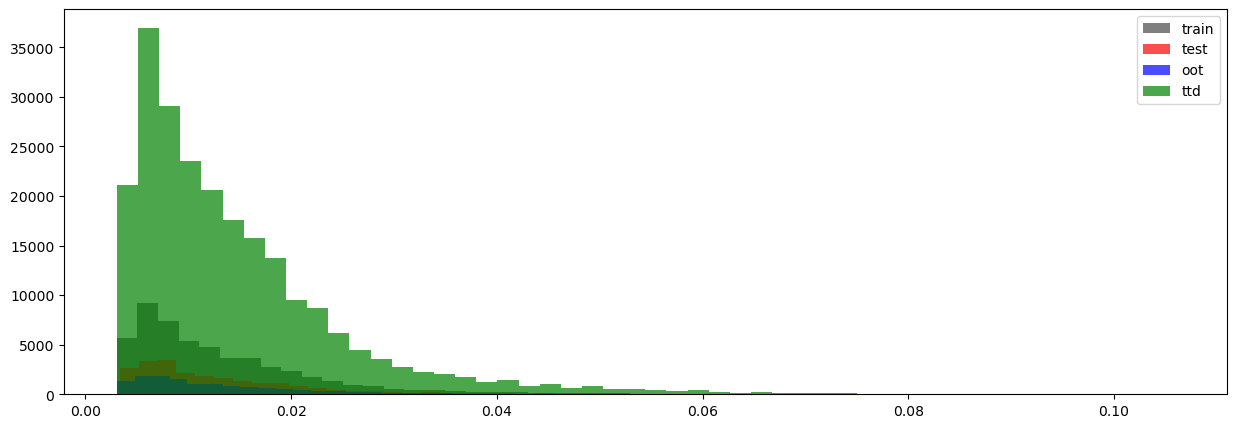

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [91]:
Train['p1'].value_counts(dropna= False).head()

p1
0.004274    2278
0.004427     887
0.007014     821
0.005782     611
0.005365     531
Name: count, dtype: int64

In [92]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     50879
[1]      2509
[2]       126
[-1]       12
Name: count, dtype: int64
bankruptcystatus
[0]     21777
[1]      1107
[2]        55
[-1]        1
Name: count, dtype: int64


In [93]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [94]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

inquiryauto12month
assetownership
sourcenonderogcount12month
inquirytelcom12month
inquirynonshortterm12month
inquiryshortterm12month
sourcenonderogcount
educationattendance
addrlastmovetaxratiodiff
addrinputtaxvalue
criminalnonfelonycount
assetpropevercount
alertregulatorycondition
addrprevioustimeoldest
criminalfelonycount
inquirycollections12month
evictiontimenewest
bankruptcychapter
addrinputproblems
subjectnewestrecord12month
inquirybanking12month
assetpropcurrenttaxtotal
addrcurrentavmratio12monthprior
assetproppurchasetimenewest
assetpropnewestmortgagetype
addrcurrenttimenewest
addrinputavmratio12monthprior
addrchangecount06month
lienjudgmentsmallclaimscount
addrchangecount03month
businessassociation
assetpersonalcount
addronfilecount
addrinputtimenewest
addrinputsubjectowned
addrcurrentlastsalesprice
addrinputavmratio60monthprior
addrchangecount12month
assetpropsalepurchaseratio
lienjudgmentcourtcount
assetproppurchasecount12month
bankruptcystatus
bankruptcycount24month
addrcurr

In [95]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquiryauto12month,[0],561.0,0.011931,0.011745,47020,248.0,0.012341,0.011723,20095.0,Yes
1,inquiryauto12month,[1],171.0,0.026283,0.026919,6506,66.0,0.023199,0.027139,2845.0,Yes
2,assetownership,[0],457.0,0.020556,0.020543,22232,198.0,0.020950,0.020661,9451.0,Yes
3,assetownership,[1],275.0,0.008788,0.008650,31294,116.0,0.008600,0.008713,13489.0,Yes
4,sourcenonderogcount12month,"[-inf, 2.0)",510.0,0.018380,0.018605,27747,219.0,0.018399,0.018701,11903.0,Yes
5,sourcenonderogcount12month,"[2.0, inf)",222.0,0.008612,0.008191,25779,95.0,0.008607,0.008172,11037.0,Yes
6,inquirytelcom12month,[0],696.0,0.013218,0.013474,52657,299.0,0.013259,0.013509,22550.0,Yes
7,inquirytelcom12month,[1],36.0,0.041427,0.020569,869,15.0,0.038462,0.020912,390.0,Yes
8,inquirynonshortterm12month,[0],429.0,0.011169,0.010917,38411,199.0,0.012140,0.010857,16392.0,Yes
9,inquirynonshortterm12month,[1],303.0,0.020046,0.020381,15115,115.0,0.017563,0.020590,6548.0,Yes


In [96]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11424 85.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.014928,0.102884,0.024141,2285,2243.0,42.0,1.84,20.00,19.78,49.41,29.63
1,0.009820,0.014928,0.012036,2285,2274.0,11.0,0.48,40.00,39.84,62.35,22.51
2,0.007311,0.009820,0.008495,2285,2270.0,15.0,0.66,60.01,59.86,80.00,20.14
3,0.005557,0.007311,0.006459,2285,2275.0,10.0,0.44,80.01,79.92,91.76,11.84
4,0.003346,0.005557,0.004640,2284,2277.0,7.0,0.31,100.00,100.00,100.00,0.00


{'Gini': 33.650000000000006, 'KS': 29.63}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6965 106.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019318,0.075169,0.026921,1394,1350.0,44.0,3.16,20.01,19.68,41.51,21.83
1,0.013640,0.019300,0.016288,1392,1368.0,24.0,1.72,40.00,39.63,64.15,24.52
2,0.009443,0.013614,0.011365,1394,1375.0,19.0,1.36,60.01,59.67,82.08,22.41
3,0.006447,0.009442,0.007794,1393,1387.0,6.0,0.43,80.01,79.90,87.74,7.84
4,0.003540,0.006447,0.005230,1392,1379.0,13.0,0.93,100.00,100.00,100.00,0.00


{'Gini': 30.64, 'KS': 24.52}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2569 26.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.016142,0.063909,0.025192,514,501.0,13.0,2.53,20.01,19.70,50.00,30.30
1,0.010449,0.016142,0.012838,514,510.0,4.0,0.78,40.02,39.76,65.38,25.62
2,0.007518,0.010445,0.008831,514,510.0,4.0,0.78,60.02,59.81,80.77,20.96
3,0.005557,0.007518,0.006539,514,510.0,4.0,0.78,80.03,79.87,96.15,16.28
4,0.003346,0.005557,0.004620,513,512.0,1.0,0.19,100.00,100.00,100.00,0.00


{'Gini': 37.269999999999996, 'KS': 30.3}
Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
9525 243.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019087,0.082728,0.029463,1906,1813.0,93.0,4.88,20.01,19.53,38.27,18.74
1,0.012993,0.019087,0.015926,1904,1850.0,54.0,2.84,40.00,39.46,60.49,21.03
2,0.008798,0.012993,0.010769,1906,1866.0,40.0,2.10,60.01,59.57,76.95,17.38
3,0.005991,0.008798,0.007369,1905,1869.0,36.0,1.89,80.01,79.70,91.77,12.07
4,0.003540,0.005991,0.004994,1904,1884.0,20.0,1.05,100.00,100.00,100.00,0.00


{'Gini': 27.689999999999998, 'KS': 21.03}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2705 32.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.017764,0.079007,0.027889,542,529.0,13.0,2.40,20.04,19.79,40.62,20.83
1,0.012098,0.017757,0.014652,540,536.0,4.0,0.74,40.00,39.84,53.12,13.28
2,0.008343,0.012067,0.010074,542,535.0,7.0,1.29,60.04,59.86,75.00,15.14
3,0.005557,0.008338,0.006936,541,540.0,1.0,0.18,80.04,80.06,78.12,1.94
4,0.003540,0.005557,0.004654,540,533.0,7.0,1.30,100.00,100.00,100.00,0.00


{'Gini': 18.93, 'KS': 20.83}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6374 42.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021595,0.100958,0.033475,1275,1259.0,16.0,1.25,20.00,19.88,38.10,18.22
1,0.014262,0.021595,0.017615,1275,1264.0,11.0,0.86,40.01,39.85,64.29,24.44
2,0.009479,0.014262,0.011752,1275,1269.0,6.0,0.47,60.01,59.89,78.57,18.68
3,0.006575,0.009479,0.007938,1275,1269.0,6.0,0.47,80.01,79.93,92.86,12.93
4,0.003063,0.006568,0.005168,1274,1271.0,3.0,0.24,100.00,100.00,100.00,0.00


{'Gini': 29.709999999999997, 'KS': 24.44}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
7432 105.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022207,0.089679,0.031776,1487,1453.0,34.0,2.29,20.01,19.83,32.38,12.55
1,0.016421,0.022207,0.019017,1486,1460.0,26.0,1.75,40.00,39.76,57.14,17.38
2,0.011824,0.016421,0.014023,1487,1461.0,26.0,1.75,60.01,59.70,81.90,22.20
3,0.007256,0.011824,0.009463,1486,1470.0,16.0,1.08,80.01,79.76,97.14,17.38
4,0.003786,0.007256,0.005688,1486,1483.0,3.0,0.20,100.00,100.00,100.00,0.00


{'Gini': 27.800000000000004, 'KS': 22.2}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
5002 83.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019972,0.078926,0.031214,1001,957.0,44.0,4.4,20.01,19.46,53.01,33.55
1,0.013763,0.019966,0.016711,1000,983.0,17.0,1.7,40.00,39.44,73.49,34.05
2,0.009479,0.013763,0.011448,1001,990.0,11.0,1.1,60.02,59.56,86.75,27.19
3,0.006425,0.009479,0.007886,1000,992.0,8.0,0.8,80.01,79.73,96.39,16.66
4,0.003786,0.006425,0.005102,1000,997.0,3.0,0.3,100.00,100.00,100.00,0.00


{'Gini': 44.58, 'KS': 34.05}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
709 10.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.017645,0.069566,0.025895,142,138.0,4.0,2.82,20.03,19.74,40.0,20.26
1,0.011916,0.017644,0.014376,142,140.0,2.0,1.41,40.06,39.77,60.0,20.23
2,0.008373,0.011883,0.009984,142,140.0,2.0,1.41,60.08,59.80,80.0,20.20
3,0.005669,0.008310,0.006787,142,141.0,1.0,0.70,80.11,79.97,90.0,10.03
4,0.003866,0.005669,0.004665,141,140.0,1.0,0.71,100.00,100.00,100.0,0.00


{'Gini': 28.310000000000002, 'KS': 20.26}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
664 0.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023544,0.079007,0.032441,133,133.0,0.0,0.0,20.03,20.03,NaN,NaN
1,0.017945,0.023542,0.020328,133,133.0,0.0,0.0,40.06,40.06,NaN,NaN
2,0.014814,0.017795,0.016368,133,133.0,0.0,0.0,60.09,60.09,NaN,NaN
3,0.011257,0.014814,0.013160,133,133.0,0.0,0.0,80.12,80.12,NaN,NaN
4,0.003786,0.011257,0.008259,132,132.0,0.0,0.0,100.00,100.00,NaN,NaN


{'Gini': nan, 'KS': nan}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
157 0.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.015664,0.039086,0.021297,32,32.0,0.0,0.0,20.38,20.38,NaN,NaN
1,0.010784,0.015450,0.013409,31,31.0,0.0,0.0,40.13,40.13,NaN,NaN
2,0.007797,0.010768,0.009286,32,32.0,0.0,0.0,60.51,60.51,NaN,NaN
3,0.005705,0.007786,0.006714,31,31.0,0.0,0.0,80.25,80.25,NaN,NaN
4,0.003866,0.005699,0.004803,31,31.0,0.0,0.0,100.00,100.00,NaN,NaN


{'Gini': nan, 'KS': nan}


### Basic Checks

In [97]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(72798.0, 53526.0, 22940.0)

In [98]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [99]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((50957, 147), (50957, 147))

In [100]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((21841, 147), (21841, 147))

In [101]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [102]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    50957.000000
 mean         0.013689
 std          0.009852
 min          0.003063
 25%          0.006918
 50%          0.010833
 75%          0.017440
 max          0.102884
 Name: p1, dtype: float64,
 count    50957.000000
 mean         0.013689
 std          0.009852
 min          0.003063
 25%          0.006918
 50%          0.010833
 75%          0.017440
 max          0.102884
 Name: p1, dtype: float64)

In [103]:
Train['client'].value_counts(dropna= False)

client
Arkansas    11424
Tower        9525
GESA         7432
Numerica     6965
Guardian     6374
SECU         5002
Bethpage     2705
CPM          2569
HFCU          709
Hawaii        664
NCU           157
Name: count, dtype: int64

In [104]:
import datetime
Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)